# Telecom Churn Case Study

Link: https://www.kaggle.com/competitions/telecom-churn-case-study-hackathon-c-65/overview

## Problem Statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

## Import Libraries

In [486]:
'''
Library Versions:
pandas: 2.1.4
numpy: 1.26.4
seaborn: 0.13.2
matplotlib: 3.8.0
scikit-learn: 1.2.2
statsmodels: 0.14.0
xgboost: 2.1.1
lightgbm: 4.5.0
imblearn: 0.11.0
'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


## Load the Data

In [487]:
train_df = pd.read_csv("train.csv")
unseen_df = pd.read_csv("test.csv")
sample_df = pd.read_csv("sample.csv")
data_dict_df = pd.read_csv("data_dictionary.csv")

print(train_df.shape)
print(unseen_df.shape)
print(sample_df.shape)
print(data_dict_df.shape)


(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


## Data Overview

In [488]:
def empty_columns(df, empty_threshold):
    # Calculate percentage of missing values per column
    missing_percentages = (df.isnull().sum() / len(df)) * 100
    # Show columns with more than the specified threshold of missing values
    columns_above_threshold = missing_percentages[missing_percentages > empty_threshold].sort_values(ascending=False)
    return pd.DataFrame({'Empty_Column': columns_above_threshold.index, 'Missing_Percentage': columns_above_threshold.values})

In [489]:
train_df.head(10)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.00,0.00,0.00,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.00,0.00,0.00,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.00,0.00,0.00,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.00,0.00,0.00,0
5,5,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,86.193,83.351,...,0,0,NaN,NaN,NaN,698,0.00,0.00,0.00,0
6,6,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,54.173,95.130,...,0,0,NaN,NaN,NaN,1083,0.00,0.00,0.00,0
7,7,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,167.861,167.869,...,0,0,1.0,1.0,1.0,584,82.26,73.56,177.14,0
8,8,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,163.550,90.250,...,0,0,NaN,NaN,NaN,2455,0.00,0.00,0.00,1
9,9,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,101.984,259.265,...,0,0,NaN,NaN,NaN,2530,0.00,0.00,0.00,0


In [490]:
train_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [491]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,69999.0,34999.000000,20207.115084,0.0,17499.5,34999.0,52498.5,69998.00
circle_id,69999.0,109.000000,0.000000,109.0,109.0,109.0,109.0,109.00
loc_og_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
std_og_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
loc_ic_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...
aon,69999.0,1220.639709,952.426321,180.0,468.0,868.0,1813.0,4337.00
aug_vbc_3g,69999.0,68.108597,269.328659,0.0,0.0,0.0,0.0,12916.22
jul_vbc_3g,69999.0,65.935830,267.899034,0.0,0.0,0.0,0.0,9165.60
jun_vbc_3g,69999.0,60.076740,257.226810,0.0,0.0,0.0,0.0,11166.21


### Handle Missing Values

#### Impute Categorical Columns

In [492]:
# Columns to convert to categorical
categorical_cols = [
    'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
    'fb_user_6', 'fb_user_7', 'fb_user_8'
]

# Impute missing values with -1 to maintain relationship
train_df[categorical_cols] = train_df[categorical_cols].fillna(-1)
unseen_df[categorical_cols] = unseen_df[categorical_cols].fillna(-1)

#### Convert Categorical Columns to Appropriate Data Types

In [493]:
# Convert categorical columns to 'category' data type
for col in categorical_cols:
    train_df[col] = train_df[col].astype('int').astype('category')
    unseen_df[col] = unseen_df[col].astype('int').astype('category')

#### Impute Numerical Columns

In [494]:
# Impute ARPU and Recharge empty values with 0
empty_numerical_columns = train_df.filter(regex = r'(arpu_|_rech_)').columns
train_df[empty_numerical_columns] = train_df[empty_numerical_columns].fillna(0)
unseen_df[empty_numerical_columns] = unseen_df[empty_numerical_columns].fillna(0)

#### Handle Negative Values in ARPU Columns

In [495]:
# Replace negative values of ARPU with 0
# List of ARPU columns
arpu_cols = [
    'arpu_6', 'arpu_7', 'arpu_8',
    'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
    'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8'
]

# Replace negative values with zero
train_df[arpu_cols] = train_df[arpu_cols].applymap(lambda x: x if x >= 0 else 0)
unseen_df[arpu_cols] = unseen_df[arpu_cols].applymap(lambda x: x if x >= 0 else 0)

#### Correct Datatype - Date Columns

In [496]:
# List of date columns
date_cols = [
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
    'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8'
]

# Convert to datetime
for col in date_cols:
    train_df[col] = pd.to_datetime(train_df[col], errors='coerce')
    unseen_df[col] = pd.to_datetime(unseen_df[col], errors='coerce')

#### Impute Date Columns

In [497]:
# Since, Last Date has no variance i.e. has similar values, we went with max to fill empty values
train_df['last_date_of_month_6'] = train_df['last_date_of_month_6'].fillna(train_df['last_date_of_month_6'].max())
train_df['last_date_of_month_7'] = train_df['last_date_of_month_7'].fillna(train_df['last_date_of_month_7'].max())
train_df['last_date_of_month_8'] = train_df['last_date_of_month_8'].fillna(train_df['last_date_of_month_8'].max())
for i in [6, 7, 8]:
    col = f'last_date_of_month_{i}'
    missing = train_df[col].isna().sum()
    print(f"Remaining NaT in '{col}': {missing}")

Remaining NaT in 'last_date_of_month_6': 0
Remaining NaT in 'last_date_of_month_7': 0
Remaining NaT in 'last_date_of_month_8': 0


#### Impute remaining empty numerical columns with Imputer

In [498]:
empty_threshold = 0
empty_columns_above_threshold = empty_columns(train_df, empty_threshold)
print("Columns with more than", empty_threshold, "% missing values:")
empty_columns_above_threshold

Columns with more than 0 % missing values:


,Empty_Column,Missing_Percentage
0,isd_ic_mou_8,5.290076
1,loc_og_t2m_mou_8,5.290076
2,loc_og_t2c_mou_8,5.290076
3,std_ic_t2o_mou_8,5.290076
4,loc_og_mou_8,5.290076
...,...,...
88,date_of_last_rech_7,1.762882
89,date_of_last_rech_6,1.572880
90,std_og_t2o_mou,1.002871
91,loc_ic_t2o_mou,1.002871


In [499]:
# Select columns with 'float64' or 'int64' types
numeric_columns_with_na = train_df.select_dtypes(include=['float64', 'int64']).columns

# Filter columns with missing values
columns_with_missing_values = train_df[numeric_columns_with_na].columns[train_df[numeric_columns_with_na].isna().any()]


# Initialize SimpleImputer with median strategy
median_imputer = SimpleImputer(strategy='median')

# Fit the imputer on train_df
train_df[columns_with_missing_values] = median_imputer.fit_transform(train_df[columns_with_missing_values])

# Transform unseen_df using the fitted imputer
unseen_df[columns_with_missing_values] = median_imputer.transform(unseen_df[columns_with_missing_values])

#### Identify and Drop Columns with Zero Variance

In [500]:
# Calculate standard deviation after handling missing values
std_dev = train_df.std(numeric_only=True)

# Identify columns with zero standard deviation
cols_with_zero_std = std_dev[std_dev == 0].index.tolist()

# Dropping below columns
train_df.drop(columns=cols_with_zero_std, inplace=True)
unseen_df.drop(columns=cols_with_zero_std, inplace=True)

print("Columns dropped due to zero variance:")
print(cols_with_zero_std)
print("Shape after dropping:", train_df.shape)

Columns dropped due to zero variance:
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']
Shape after dropping: (69999, 162)


In [501]:
train_df.drop(columns=['id'], inplace=True)
unseen_ids = unseen_df['id']
unseen_df.drop(columns=['id'], inplace=True)
print(train_df.shape)
print(unseen_df.shape)


(69999, 161)
(30000, 160)


## Derive New Features

### Days since last recharge

In [502]:
# Calculate 'days_since_last_rech' columns
for i in [6, 7, 8]:
    # Get the number of days in the month
    days_in_month = train_df[f'last_date_of_month_{i}'].dt.daysinmonth

    # Calculate days since last recharge
    train_df[f'days_since_last_rech_{i}'] = (train_df[f'last_date_of_month_{i}'] - train_df[f'date_of_last_rech_{i}']).dt.days
    unseen_df[f'days_since_last_rech_{i}'] = (unseen_df[f'last_date_of_month_{i}'] - unseen_df[f'date_of_last_rech_{i}']).dt.days
    # Calculate days since last data recharge
    train_df[f'days_since_last_rech_data_{i}'] = (train_df[f'last_date_of_month_{i}'] - train_df[f'date_of_last_rech_data_{i}']).dt.days
    unseen_df[f'days_since_last_rech_data_{i}'] = (unseen_df[f'last_date_of_month_{i}'] - unseen_df[f'date_of_last_rech_data_{i}']).dt.days

    # Fill missing values
    train_df[f'days_since_last_rech_{i}'] = train_df[f'days_since_last_rech_{i}'].fillna(days_in_month)
    unseen_df[f'days_since_last_rech_{i}'] = unseen_df[f'days_since_last_rech_{i}'].fillna(days_in_month)
    train_df[f'days_since_last_rech_data_{i}'] = train_df[f'days_since_last_rech_data_{i}'].fillna(days_in_month)
    unseen_df[f'days_since_last_rech_data_{i}'] = unseen_df[f'days_since_last_rech_data_{i}'].fillna(days_in_month)


In [503]:
empty_threshold = 0
empty_columns_above_threshold = empty_columns(train_df, empty_threshold)
print("Columns with more than", empty_threshold, "% missing values:")
empty_columns_above_threshold

Columns with more than 0 % missing values:


,Empty_Column,Missing_Percentage
0,date_of_last_rech_8,3.515765
1,date_of_last_rech_7,1.762882
2,date_of_last_rech_6,1.572880


### ARPU change between months

In [504]:
# ARPU change between months
train_df['arpu_change_6_7'] = train_df['arpu_7'] - train_df['arpu_6']
train_df['arpu_change_7_8'] = train_df['arpu_8'] - train_df['arpu_7']

unseen_df['arpu_change_6_7'] = unseen_df['arpu_7'] - unseen_df['arpu_6']
unseen_df['arpu_change_7_8'] = unseen_df['arpu_8'] - unseen_df['arpu_7']


### Total recharge amount change between months

In [505]:
# Total recharge amount change between months
train_df['total_rech_amt_change_6_7'] = train_df['total_rech_amt_7'] - train_df['total_rech_amt_6']
train_df['total_rech_amt_change_7_8'] = train_df['total_rech_amt_8'] - train_df['total_rech_amt_7']

unseen_df['total_rech_amt_change_6_7'] = unseen_df['total_rech_amt_7'] - unseen_df['total_rech_amt_6']
unseen_df['total_rech_amt_change_7_8'] = unseen_df['total_rech_amt_8'] - unseen_df['total_rech_amt_7']

### Total data volume for each month

In [506]:
# Total data volume for each month
train_df['total_vol_data_mb_6'] = train_df['vol_2g_mb_6'] + train_df['vol_3g_mb_6']
train_df['total_vol_data_mb_7'] = train_df['vol_2g_mb_7'] + train_df['vol_3g_mb_7']
train_df['total_vol_data_mb_8'] = train_df['vol_2g_mb_8'] + train_df['vol_3g_mb_8']


unseen_df['total_vol_data_mb_6'] = unseen_df['vol_2g_mb_6'] + unseen_df['vol_3g_mb_6']
unseen_df['total_vol_data_mb_7'] = unseen_df['vol_2g_mb_7'] + unseen_df['vol_3g_mb_7']
unseen_df['total_vol_data_mb_8'] = unseen_df['vol_2g_mb_8'] + unseen_df['vol_3g_mb_8']

### Total Data Recharge Amount for the 'Good Phase'

In [507]:
#Total Data Recharge Amount for the 'Good Phase'
train_df['total_rech_data_amt_6'] = train_df['total_rech_data_6'] * train_df['av_rech_amt_data_6']
train_df['total_rech_data_amt_7'] = train_df['total_rech_data_7'] * train_df['av_rech_amt_data_7']
train_df['total_amt_6'] = train_df['total_rech_data_amt_6'] + train_df['total_rech_amt_6']
train_df['total_amt_7'] = train_df['total_rech_data_amt_7'] + train_df['total_rech_amt_7']
train_df['total_avg_amt_6_7'] = train_df[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [508]:
#Total Data Recharge Amount for the 'Good Phase' (Unseen Test Dataset)
unseen_df['total_rech_data_amt_6'] = unseen_df['total_rech_data_6'] * unseen_df['av_rech_amt_data_6']
unseen_df['total_rech_data_amt_7'] = unseen_df['total_rech_data_7'] * unseen_df['av_rech_amt_data_7']
unseen_df['total_amt_6'] = unseen_df['total_rech_data_amt_6'] + unseen_df['total_rech_amt_6']
unseen_df['total_amt_7'] = unseen_df['total_rech_data_amt_7'] + unseen_df['total_rech_amt_7']
unseen_df['total_avg_amt_6_7'] = unseen_df[['total_amt_6', 'total_amt_7']].mean(axis=1)

### Dropping the columns (Not useful anymore and redundant)

In [509]:
# Dropping the columns (Not useful anymore and redundant) for high value customer or churn

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8']

train_df.drop(drop_data_cols, axis=1, inplace=True)
unseen_df.drop(drop_data_cols, axis=1, inplace=True)

### Filtering High value customers

In [510]:
cutoff = train_df['total_avg_amt_6_7'].quantile(0.7)
cutoff

477.5

In [511]:

# High value customers where total average recharge is more than 477.5
allcust_train_df = train_df.copy()
train_df = train_df[(train_df['total_avg_amt_6_7'] > cutoff)].copy()

print(train_df.shape)

(20998, 171)


## Handle Outliers

In [512]:
# List of numerical columns
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Exclude target variable and IDs from capping
numerical_cols = [col for col in numerical_cols if col not in ['churn_probability']]

In [513]:
quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
train_df[numerical_cols].quantile(quantiles).T

,0.00,0.01,0.02,0.03,0.04,0.05,0.95,0.96,0.97,0.98,0.99,1.00
arpu_6,0.0,0.8082,39.28866,67.67658,92.83448,112.51380,1239.64505,1330.70564,1448.37290,1619.16844,1981.25437,27731.088
arpu_7,0.0,0.5637,43.17316,73.97559,94.52792,112.67105,1247.69875,1338.17744,1459.51569,1632.91214,1997.15375,35145.834
arpu_8,0.0,0.0000,0.00000,0.00000,0.50000,9.87150,1246.32110,1347.39756,1464.97500,1651.67484,1971.59247,33543.624
onnet_mou_6,0.0,0.0000,0.00000,0.00000,0.00000,0.00000,1142.44700,1282.38040,1454.57850,1724.37420,2161.86800,7376.710
onnet_mou_7,0.0,0.0000,0.00000,0.00000,0.00000,0.00000,1189.14100,1324.04960,1483.66800,1757.15160,2238.77590,8157.780
...,...,...,...,...,...,...,...,...,...,...,...,...
total_vol_data_mb_7,0.0,0.0000,0.00000,0.00000,0.00000,0.00000,2006.59900,2221.41680,2525.62280,3063.69260,4246.34070,28395.420
total_vol_data_mb_8,0.0,0.0000,0.00000,0.00000,0.00000,0.00000,1978.23200,2201.52000,2530.98060,3087.21020,4127.07600,30036.200
total_amt_6,0.0,0.0000,50.00000,129.91000,190.00000,243.00000,2939.45000,3243.24000,3770.45000,4530.00000,6287.21000,57866.000
total_amt_7,0.0,0.0000,20.00000,110.00000,169.88000,230.85000,3142.15000,3465.12000,3996.27000,5130.42000,7208.48000,56075.000


In [514]:
# Cap outliers and remove < 0.1 and > 0.99 quantile outliers
for col in numerical_cols:
    lower_cap = train_df[col].quantile(0.01)
    upper_cap = train_df[col].quantile(0.99)
    train_df[col] = np.clip(train_df[col], lower_cap, upper_cap)

## Remove Remaining Redundant Columns

In [515]:
# Drop the original date columns as they are no longer needed
date_cols_to_drop = [
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
    'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8'
]
train_df.drop(columns=date_cols_to_drop, inplace=True)
unseen_df.drop(columns=date_cols_to_drop, inplace=True)


In [516]:
train_df.isnull().sum().sort_values(ascending=False)

arpu_6               0
arpu_2g_7            0
max_rech_data_7      0
max_rech_data_8      0
count_rech_2g_6      0
                    ..
loc_ic_t2t_mou_7     0
loc_ic_t2t_mou_8     0
loc_ic_t2m_mou_6     0
loc_ic_t2m_mou_7     0
total_avg_amt_6_7    0
Length: 162, dtype: int64

## Exploratory data analysis (EDA) Visualisation

### Functions

In [517]:
#Function to plot bar graph
def plot_bar_graph(dataframe,x_axis,y_axis,xlabel,ylabel,title, showChurnXTicks):
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("husl", len(dataframe[x_axis].unique())) # Color Palette
    barplot = sns.barplot(x=x_axis, y=y_axis, data=dataframe, hue=x_axis, palette=palette, dodge=False, legend=False) #Bar Plot
    # Annotate each bar with the temperature value
    for index, row in dataframe.iterrows():
        barplot.text(index, row[y_axis], round(row[y_axis], 2), color='black', ha="center")

    plt.xlabel(xlabel) #x axis label
    plt.ylabel(ylabel) #y axis label
    plt.title(title) #title
    if(showChurnXTicks):
        plt.xticks(ticks=[0, 1], labels=['Not Churned', 'Churned'], rotation=0)
    plt.show()

In [518]:
#Function to plot bar graph with multiple bars
def plot_multiple_bar_graph(dataframe, columns, churn_column, month_mapping, xlabel, ylabel, title, figsize=(12, 8)):
    # Filter the necessary columns
    columns_to_plot = columns + [churn_column]
    df_filtered = dataframe[columns_to_plot]

    # Reshape the data to long format
    df_long = df_filtered.melt(id_vars=churn_column, var_name='Month', value_name='KPI')

    # Map churn column and month names to meaningful labels
    df_long[churn_column] = df_long[churn_column].map({0: 'Not Churned', 1: 'Churned'})
    df_long['Month'] = df_long['Month'].map(month_mapping)

    month_order = list(month_mapping.values())
    df_long['Month'] = pd.Categorical(df_long['Month'], categories=month_order, ordered=True)

    # Calculate median KPI values for each churn_probability and month
    df_median = df_long.groupby([churn_column, 'Month'], as_index=False)['KPI'].mean()

    # Plot the bar chart
    plt.figure(figsize=figsize)
    barplot = sns.barplot(x=churn_column, y='KPI', hue='Month', data=df_median, palette='husl')

    # Annotate each bar with its value
    for p in barplot.patches:
        barplot.annotate(
            format(p.get_height(), '.2f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
            textcoords='offset points'
        )

    # Add labels and title
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)

    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the legend
    plt.legend(title='Month', fontsize=10, title_fontsize=12)

    # Show the plot
    plt.show()


### Target Variable Imbalance Analysis

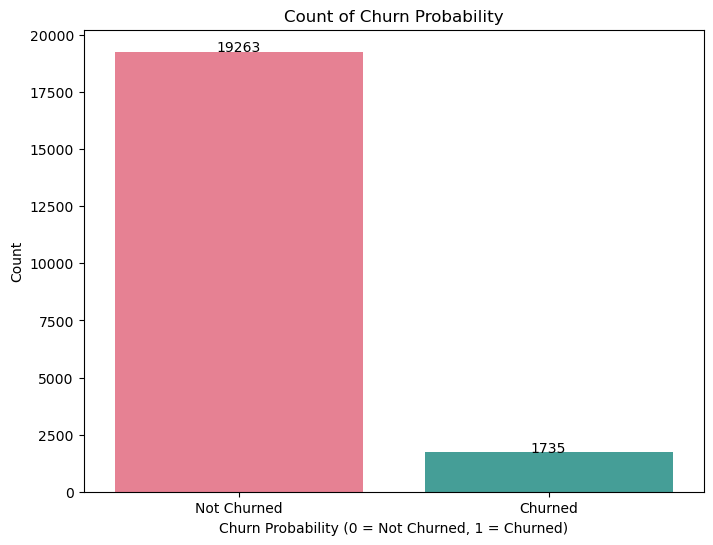

In [519]:
# Calculate the churn count
churn_counts = train_df['churn_probability'].value_counts().reset_index()

# Plot the median temperature for each season to visualize the correlation
plot_bar_graph(dataframe = churn_counts, x_axis = 'churn_probability', y_axis = 'count', xlabel = 'Churn Probability (0 = Not Churned, 1 = Churned)', 
               ylabel = 'Count', title = 'Count of Churn Probability', showChurnXTicks=True)


<div class="alert alert-block alert-success">
This imbalance indicates that churned customers represent a small portion of the data, potentially leading to challenges in model training. This imbalance could bias the model toward predicting the majority class (Not Churned). Resampling techniques like SMOTE or undersampling, or using metrics like F1-score or Precision-Recall AUC, can be used. 

<b>Since, In Kaggle calculations is tested on "accuracy", we are still moving with it.</b>
</div>

### Average Revenue per user Anaysis

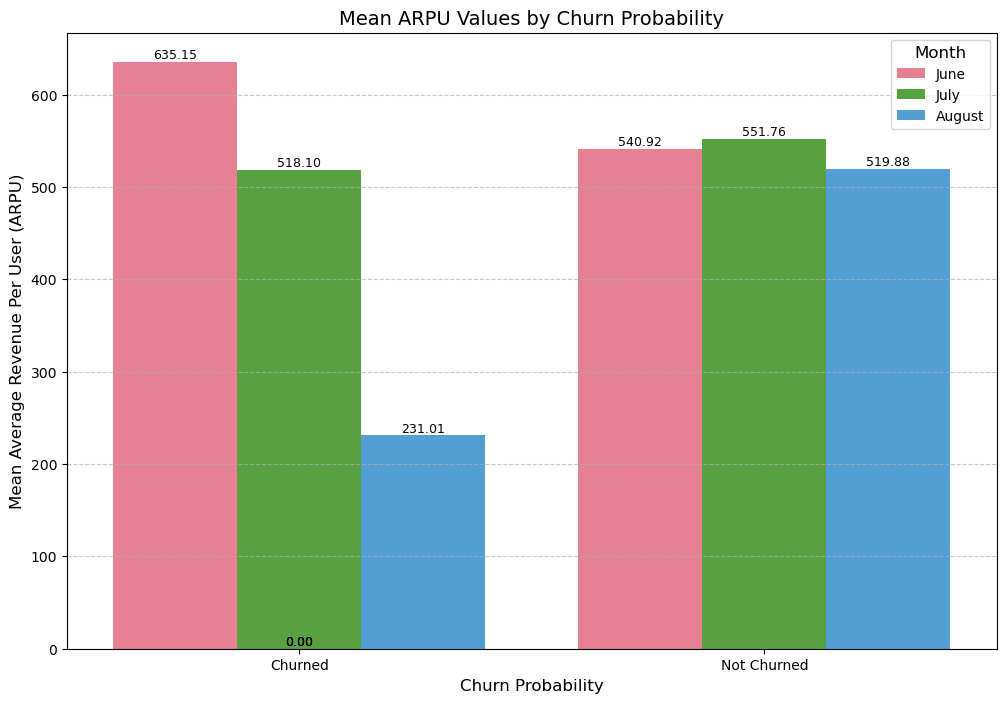

In [520]:
arpu_columns = ['arpu_6', 'arpu_7', 'arpu_8']
churn_column = 'churn_probability'
month_mapping = {'arpu_6': 'June', 'arpu_7': 'July', 'arpu_8': 'August'}

plot_multiple_bar_graph(
    dataframe=train_df,
    columns=arpu_columns,
    churn_column=churn_column,
    month_mapping=month_mapping,
    xlabel='Churn Probability',
    ylabel='Mean Average Revenue Per User (ARPU)',
    title='Mean ARPU Values by Churn Probability'
)

<div class="alert alert-block alert-success">
Customers who churned had higher ARPU in June and July but saw a significant drop in August, possibly reflecting reduced engagement before leaving. Meanwhile, non-churned customers maintained consistent ARPU across all months, showing stable usage patterns. The difference in ARPU trends suggests churned customers may initially contribute more revenue but reduce closer to churn
</div>

### Total Data Volume Usage

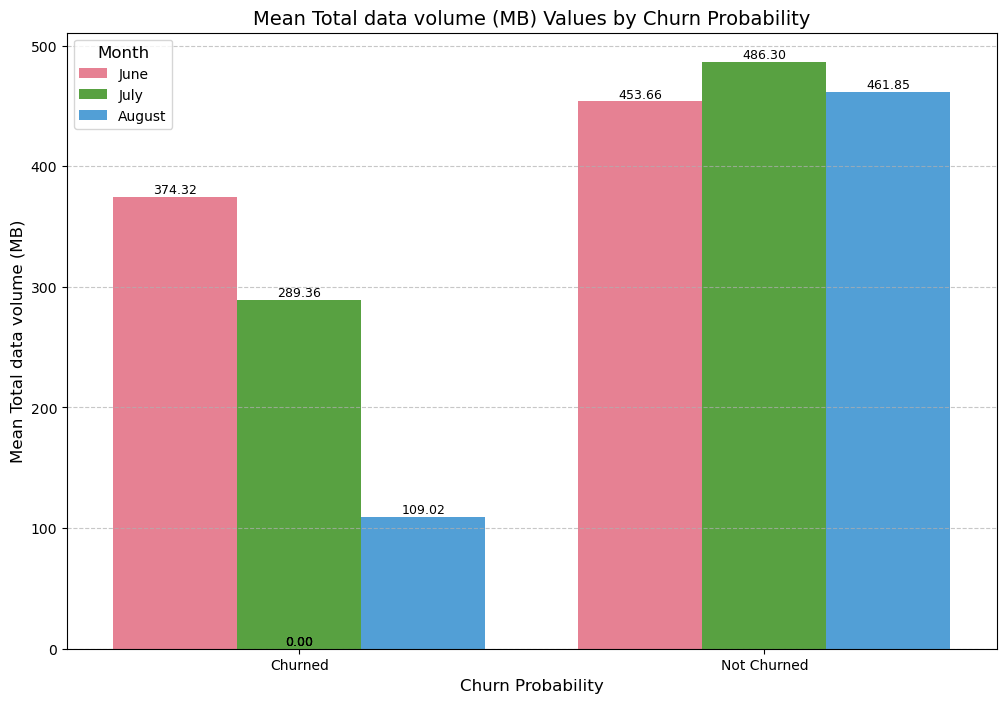

In [521]:
columns = ['total_vol_data_mb_6', 'total_vol_data_mb_7', 'total_vol_data_mb_8']
churn_column = 'churn_probability'
month_mapping = {'total_vol_data_mb_6': 'June', 'total_vol_data_mb_7': 'July', 'total_vol_data_mb_8': 'August'}

plot_multiple_bar_graph(
    dataframe=train_df,
    columns=columns,
    churn_column=churn_column,
    month_mapping=month_mapping,
    xlabel='Churn Probability',
    ylabel='Mean Total data volume (MB)',
    title='Mean Total data volume (MB) Values by Churn Probability'
)

<div class="alert alert-block alert-success">
Churned customers exhibit a higher data usage in June and July compared to non-churned customers but show a sharp decline in August, with significantly reduced engagement before leaving. Conversely, non-churned customers maintain consistently high data usage across all months, indicating stable usage patterns.
</div>

### Outgoing minutes of usage

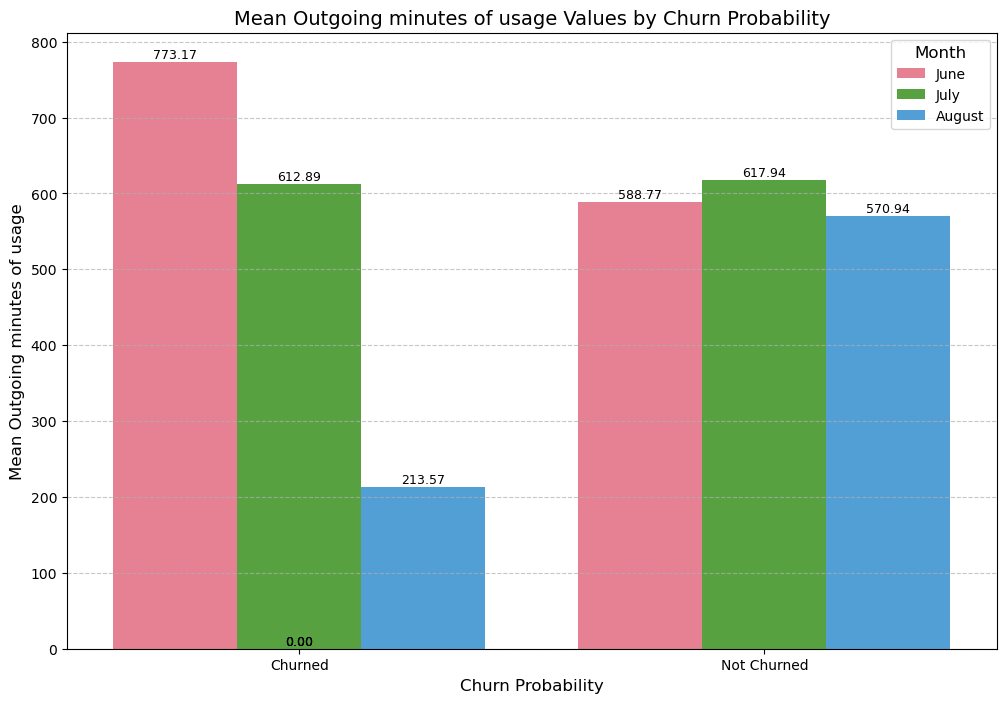

In [522]:
columns = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
churn_column = 'churn_probability'
month_mapping = {'total_og_mou_6': 'June', 'total_og_mou_7': 'July', 'total_og_mou_8': 'August'}

plot_multiple_bar_graph(
    dataframe=train_df,
    columns=columns,
    churn_column=churn_column,
    month_mapping=month_mapping,
    xlabel='Churn Probability',
    ylabel='Mean Outgoing minutes of usage',
    title='Mean Outgoing minutes of usage Values by Churn Probability'
)

<div class="alert alert-block alert-success">
Churned customers display significantly higher outgoing call activity in June and July but exhibit a sharp decline in August, suggesting disengagement before leaving.
</div>

### Incoming minutes of usage

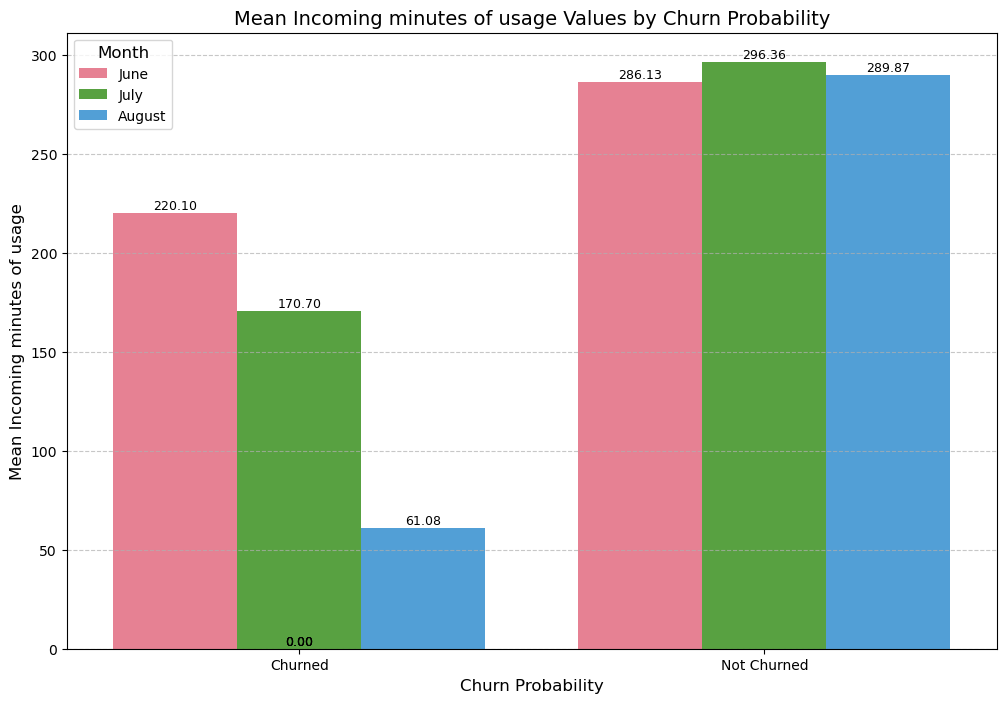

In [523]:
columns = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
churn_column = 'churn_probability'
month_mapping = {'total_ic_mou_6': 'June', 'total_ic_mou_7': 'July', 'total_ic_mou_8': 'August'}

plot_multiple_bar_graph(
    dataframe=train_df,
    columns=columns,
    churn_column=churn_column,
    month_mapping=month_mapping,
    xlabel='Churn Probability',
    ylabel='Mean Incoming minutes of usage',
    title='Mean Incoming minutes of usage Values by Churn Probability'
)

<div class="alert alert-block alert-success">
Churned customers display significantly higher incoming call activity in June and July but exhibit a sharp decline in August, suggesting disengagement before leaving.
</div>

### Incoming and Minutes of Usage (HeatMap Analysis)

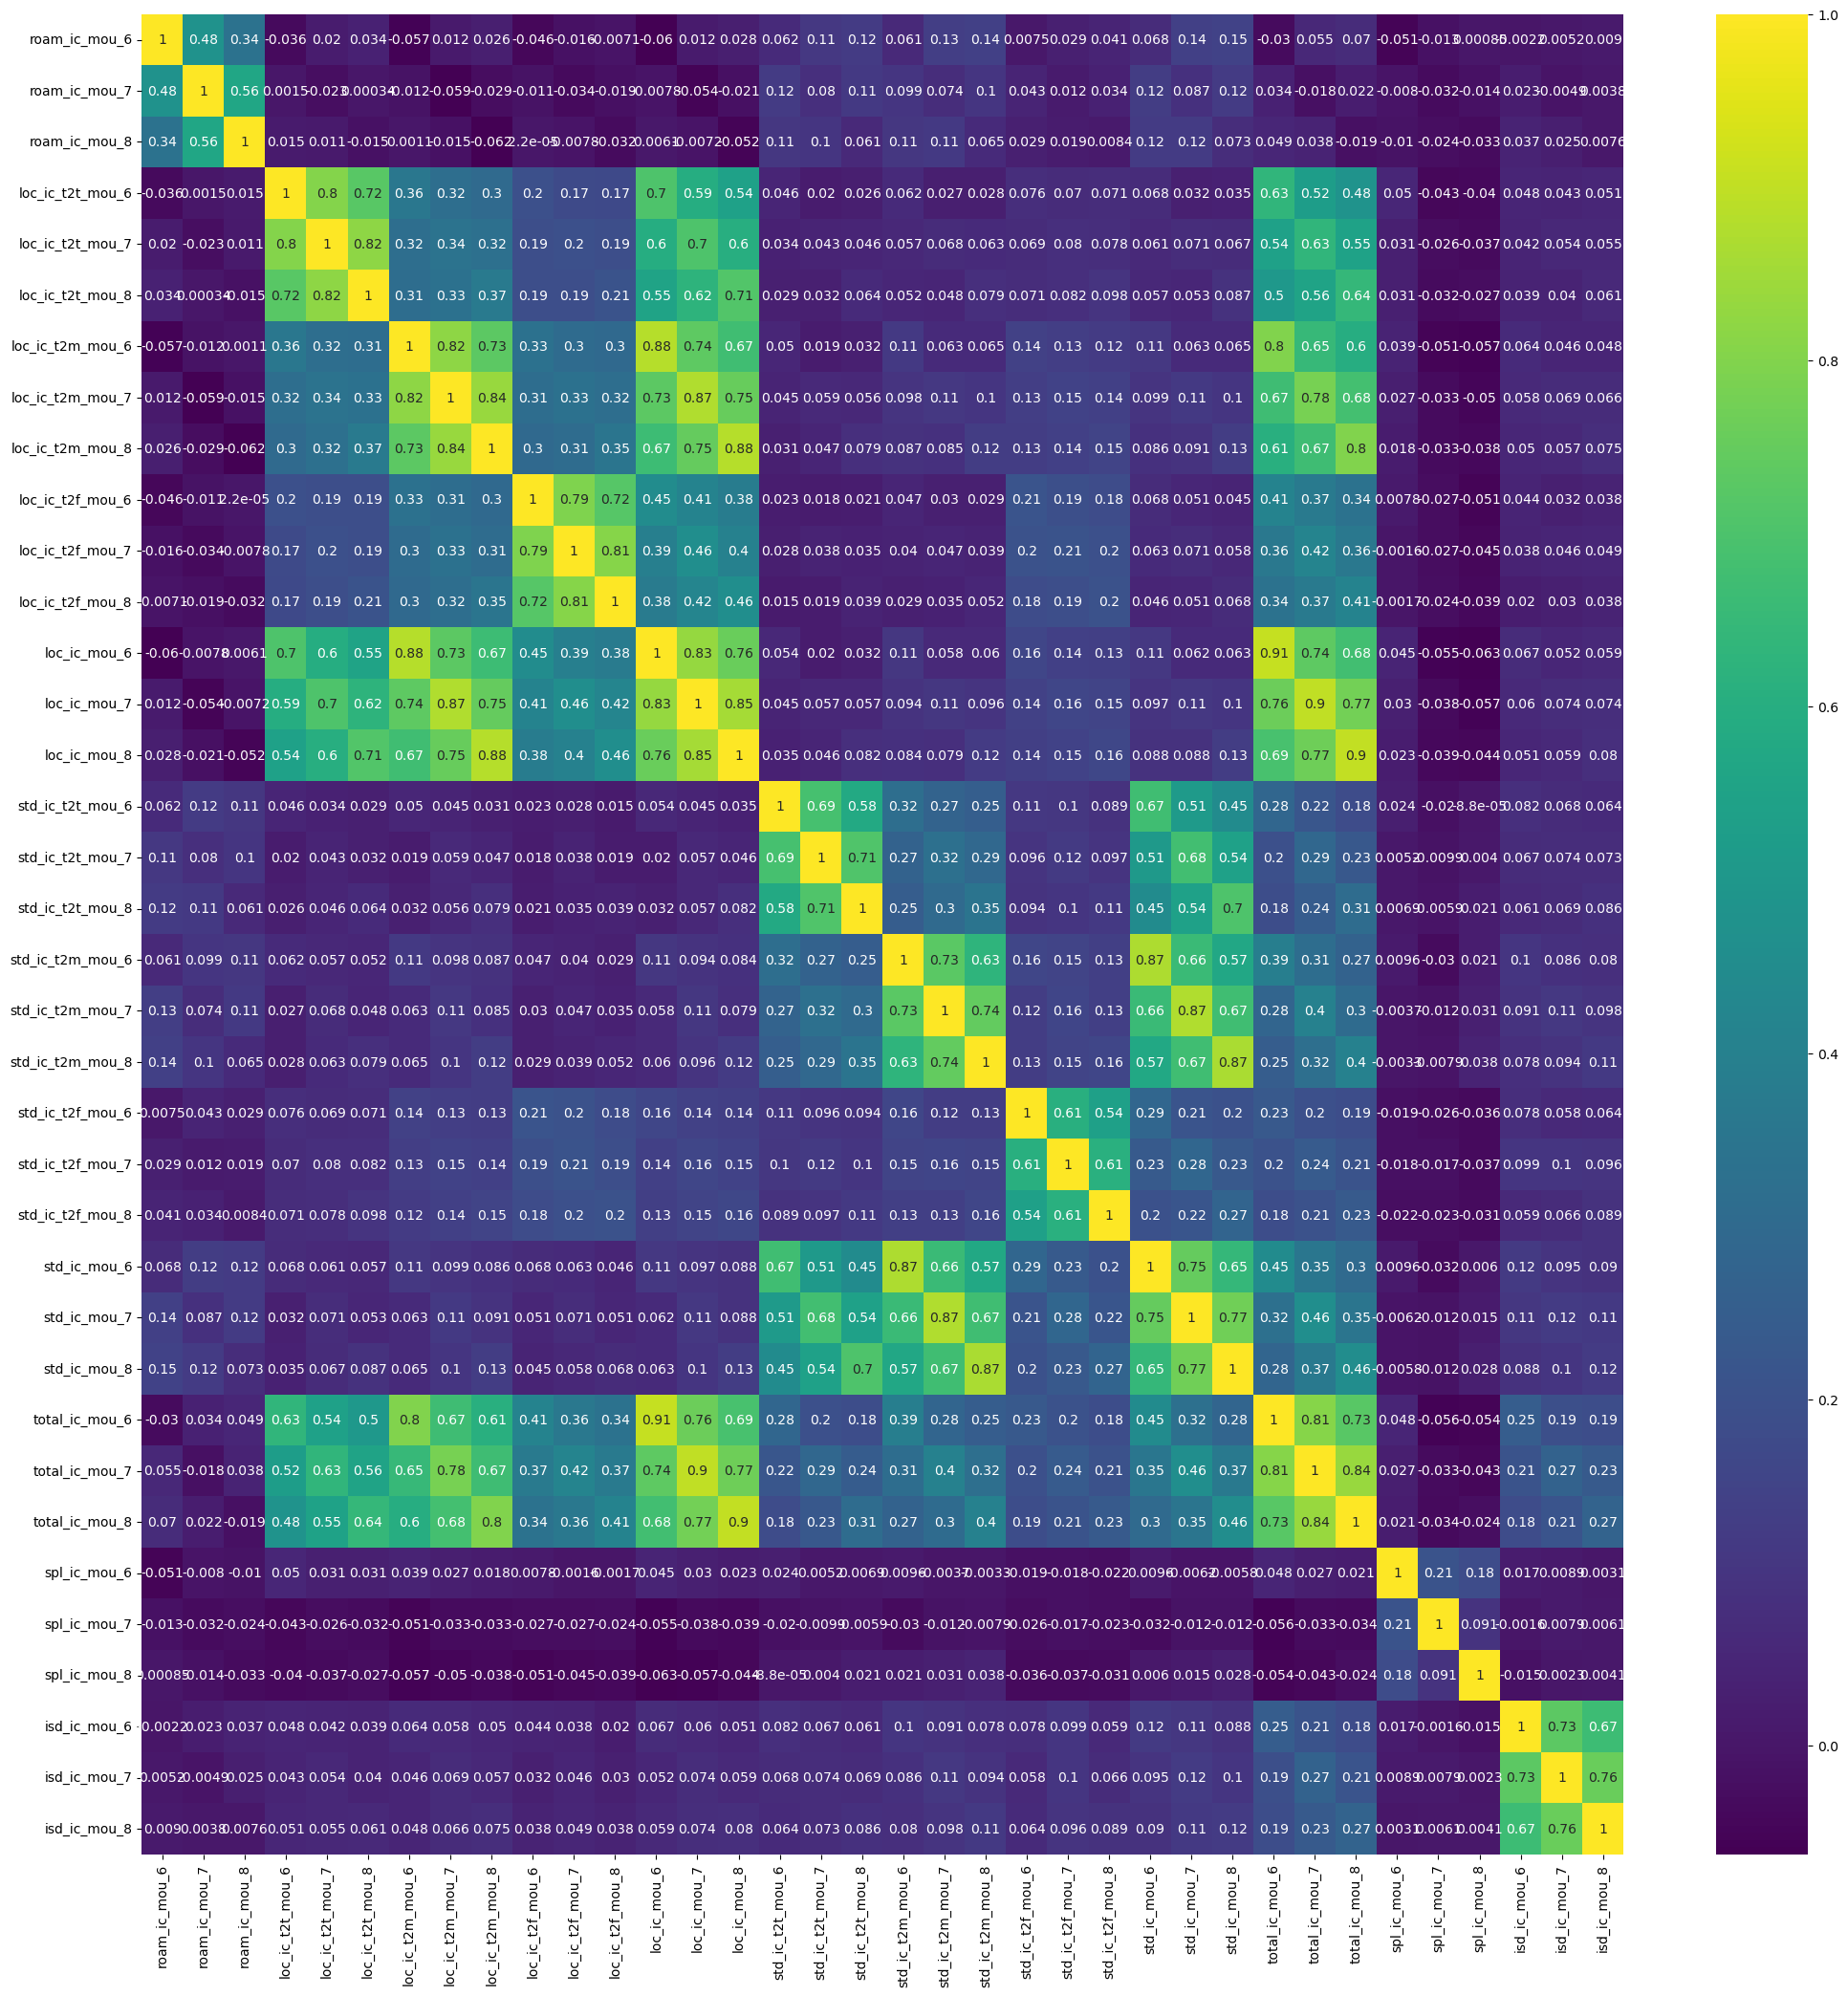

In [524]:
ic_mou_df = train_df.loc[:, train_df.columns.str.contains('ic') & train_df.columns.str.contains('mou')]
plt.figure(figsize=(25, 25))
sns.heatmap(ic_mou_df.corr(), annot=True, cmap='viridis')
plt.show()

<div class="alert alert-block alert-success">
Notably, variables such as total_ic_mou and loc_ic_t2t_mou show strong correlations, indicating their interdependence.
</div>

## Feature Scaling

In [525]:
# List of numerical columns to scale
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Exclude target variable from scaling
numerical_cols = [col for col in numerical_cols if col not in ['churn_probability']]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
unseen_df[numerical_cols] = scaler.transform(unseen_df[numerical_cols])

## Encoding Categorical Variables (Dummies)

In [526]:
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True, dtype=int)
unseen_df = pd.get_dummies(unseen_df, columns=categorical_cols, drop_first=True, dtype=int)

In [527]:
train_df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,night_pck_user_7_0,night_pck_user_7_1,night_pck_user_8_0,night_pck_user_8_1,fb_user_6_0,fb_user_6_1,fb_user_7_0,fb_user_7_1,fb_user_8_0,fb_user_8_1
4,-0.861553,-1.173157,-1.037316,-0.572376,-0.605392,-0.563422,-0.720825,-0.755521,-0.787302,0.827705,...,1,0,1,0,0,1,0,1,0,1
15,0.089066,-0.478662,-0.414788,-0.598991,-0.557366,-0.080068,-0.123386,-0.067429,-0.324963,-0.277571,...,0,0,1,0,0,1,0,0,0,1
23,1.628667,0.993985,-0.042735,1.483827,0.270989,-0.576873,-0.177705,0.178007,0.143196,-0.277571,...,0,0,0,0,0,0,0,0,0,0
24,-0.494370,-0.548989,-0.672079,-0.396007,-0.525682,-0.502509,0.368309,0.308633,-0.263453,-0.277571,...,1,0,1,0,1,0,1,0,1,0
27,-0.442579,-0.552011,-0.196478,-0.603529,-0.589550,-0.546609,-0.545879,-0.482215,-0.360133,-0.277571,...,1,0,1,0,0,1,0,1,0,1


In [528]:
unseen_df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,night_pck_user_7_0,night_pck_user_7_1,night_pck_user_8_0,night_pck_user_8_1,fb_user_6_0,fb_user_6_1,fb_user_7_0,fb_user_7_1,fb_user_8_0,fb_user_8_1
0,-1.277856,-1.348413,-1.134934,-0.546620,-0.568705,-0.519836,-0.713544,-0.769003,-0.725151,-0.277571,...,0,0,0,0,0,0,0,0,0,0
1,-0.376343,-0.093156,-0.355402,-0.439351,-0.518726,-0.528230,0.237737,0.567120,0.163001,-0.277571,...,0,0,0,0,0,0,0,0,0,0
2,-0.612218,-0.318102,0.658045,-0.606080,-0.598174,-0.557596,-0.812719,-0.738074,-0.699969,0.192439,...,0,0,0,0,0,0,0,0,0,0
3,-1.413053,-1.052719,-1.240244,-0.611550,-0.611752,-0.579158,-0.759756,-0.377352,-0.751836,-0.277571,...,0,0,0,0,0,0,0,0,0,0
4,-0.676527,-0.397824,-0.217440,0.481543,0.833962,1.219446,-0.711753,-0.787855,-0.628150,-0.277571,...,0,0,0,0,0,0,0,0,0,0


## Check for Multicollinearity

### Heatmap of the features

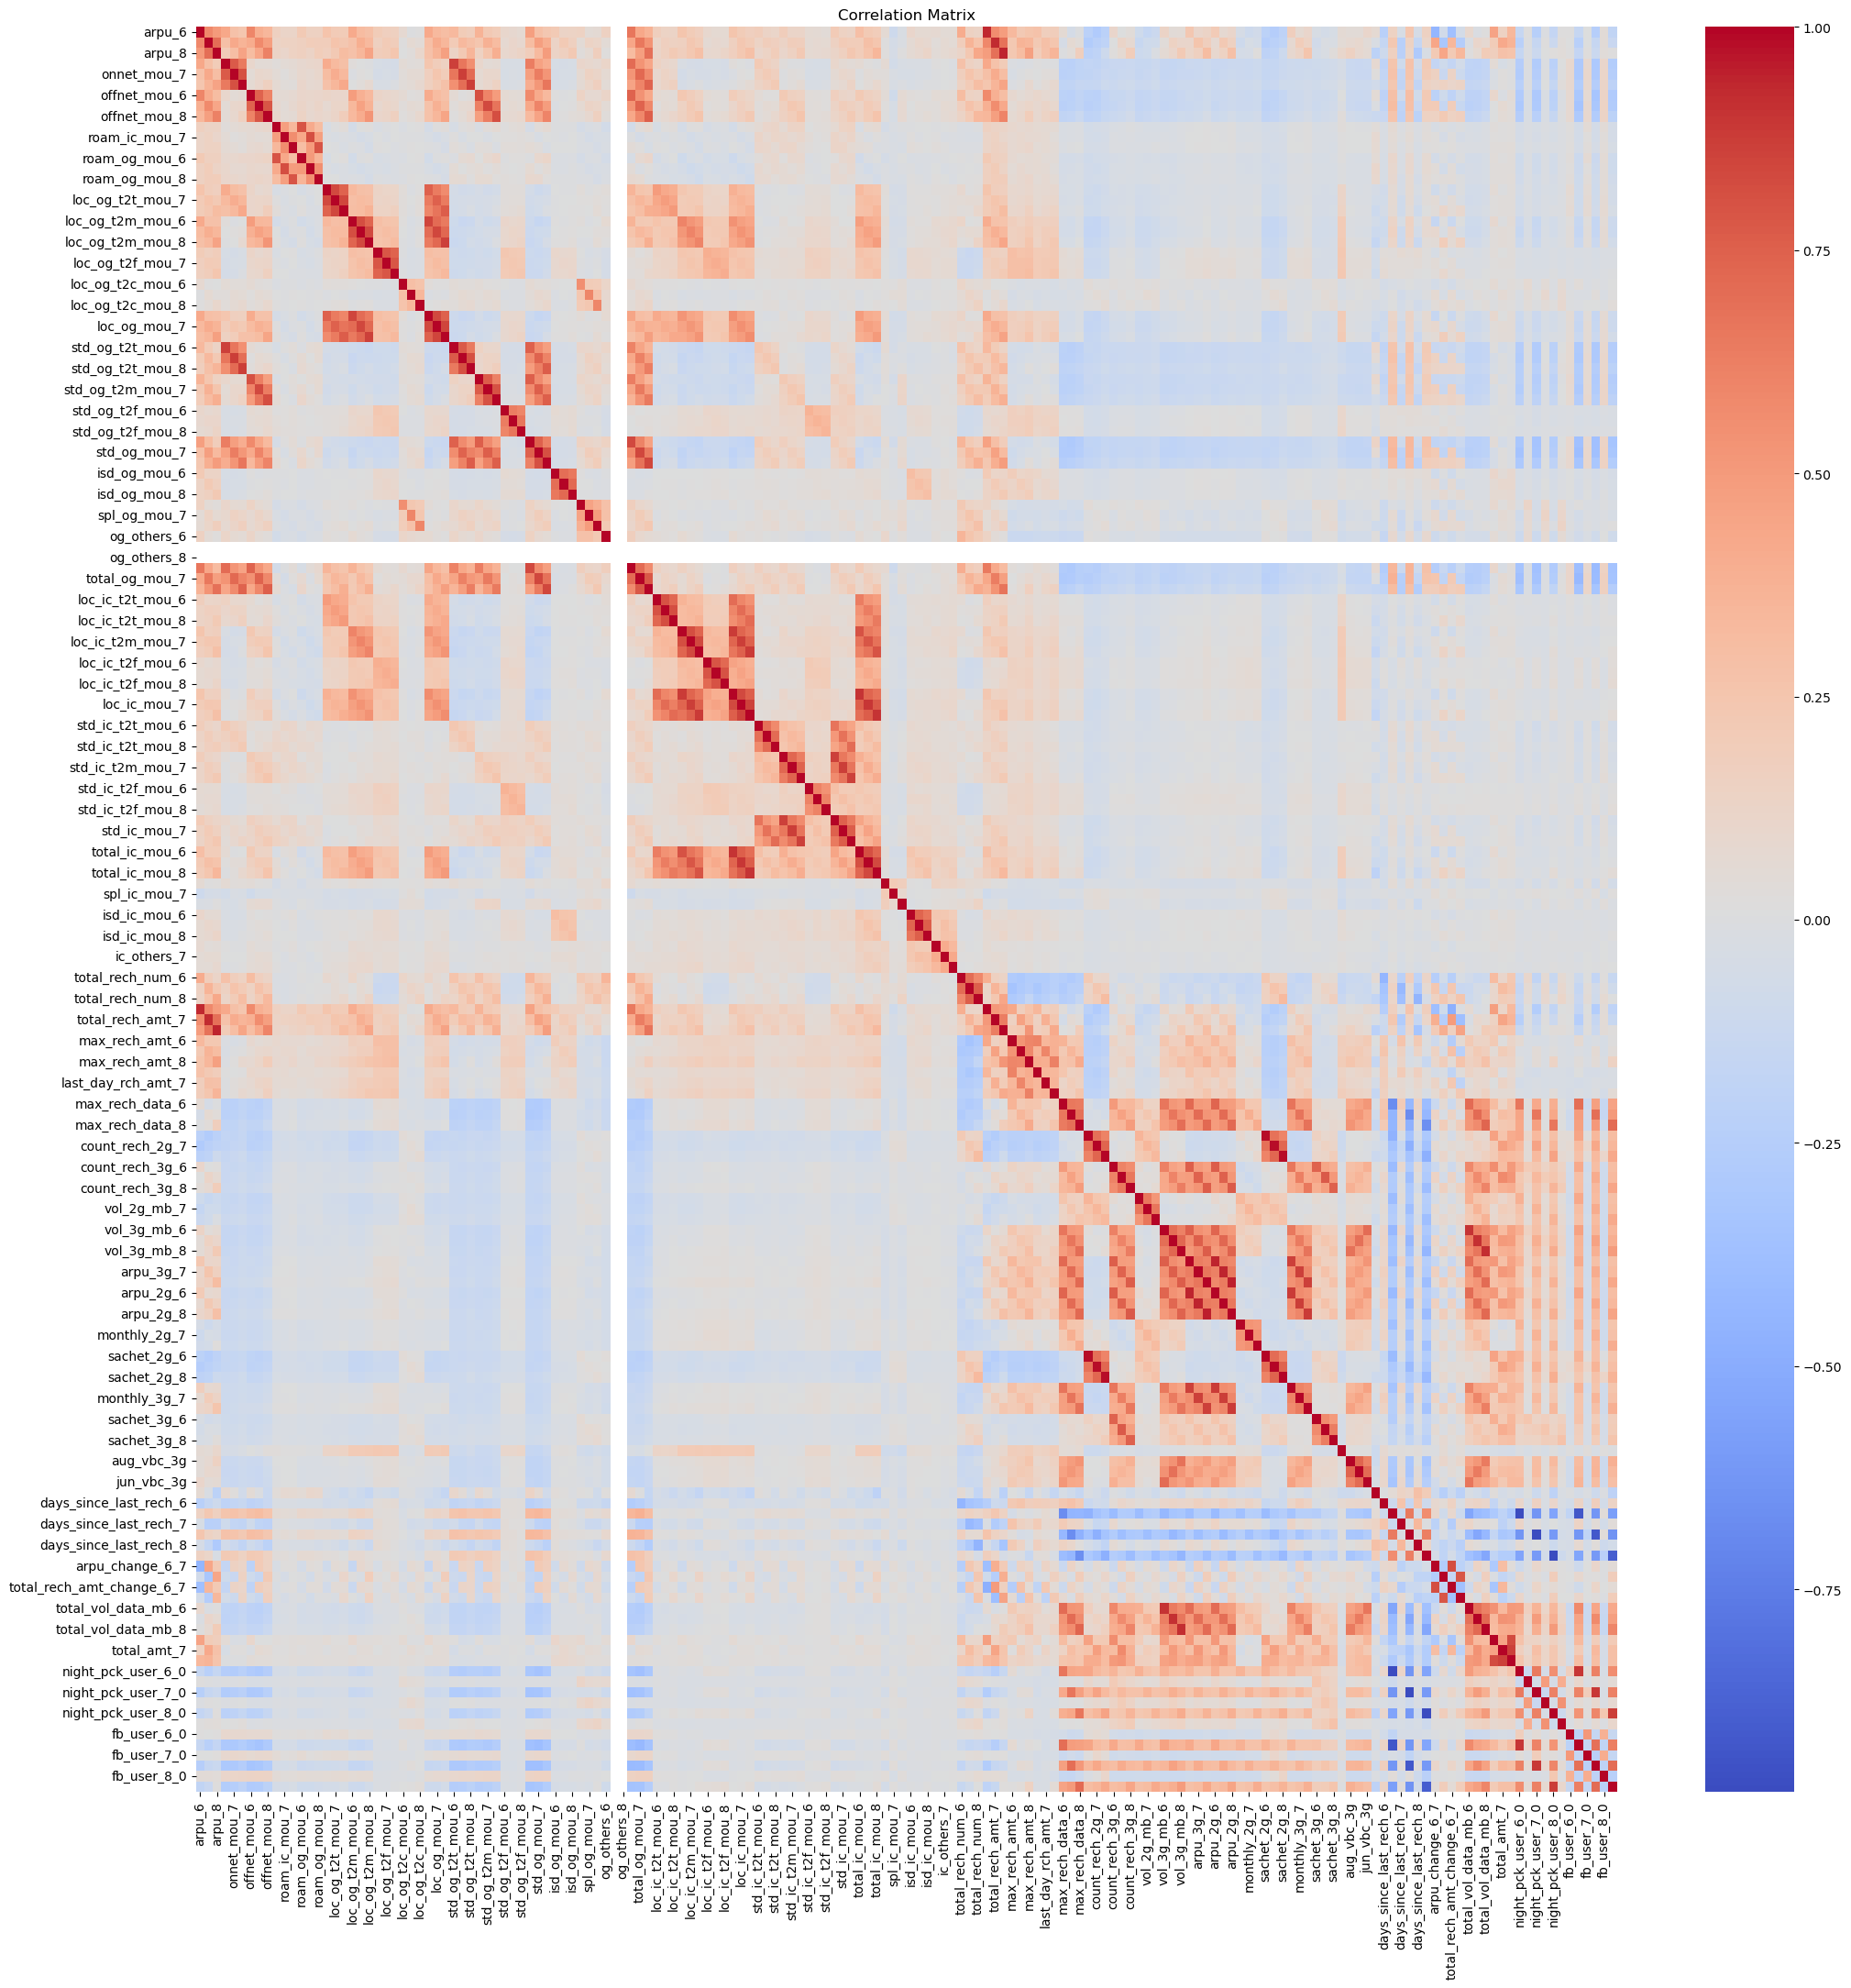

In [529]:
# Compute correlation matrix
corr_matrix = train_df.corr()

# Plot heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

<div class="alert alert-block alert-success">
Some groups of variables show clustered patterns of high correlation, suggesting they may represent similar information or redundant features.
</div>

### Drop Highly correlated features

In [530]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,night_pck_user_7_0,night_pck_user_7_1,night_pck_user_8_0,night_pck_user_8_1,fb_user_6_0,fb_user_6_1,fb_user_7_0,fb_user_7_1,fb_user_8_0,fb_user_8_1
arpu_6,NaN,0.590225,0.501951,0.432978,0.279571,0.248646,0.597994,0.391418,0.346693,0.160227,...,-0.242961,-0.007750,-0.158963,0.012110,0.014774,-0.149074,0.005181,-0.245675,0.044508,-0.176846
arpu_7,NaN,NaN,0.694023,0.283100,0.423469,0.361999,0.406031,0.578189,0.478673,0.134372,...,-0.147953,0.016563,-0.118014,0.028179,0.009302,-0.235101,0.009602,-0.147401,0.046530,-0.133396
arpu_8,NaN,NaN,NaN,0.198274,0.300242,0.453081,0.312370,0.436741,0.619548,0.127922,...,-0.119379,0.006589,0.024928,0.038654,0.011406,-0.163052,0.019243,-0.125164,0.040141,0.014740
onnet_mou_6,NaN,NaN,NaN,NaN,0.769881,0.649791,0.102312,0.051966,0.053175,0.031785,...,-0.269349,-0.009791,-0.213666,0.003793,0.093039,-0.291426,0.085624,-0.305232,0.106612,-0.261831
onnet_mou_7,NaN,NaN,NaN,NaN,NaN,0.811723,0.056729,0.098040,0.090623,0.054559,...,-0.258581,-0.000621,-0.200784,0.017543,0.087104,-0.304735,0.096479,-0.296862,0.114452,-0.249618


In [531]:
# Find features with correlation greater than 0.9
threshold = 0.9
highly_correlated_cols = [column for column in upper.columns if any(upper[column] > threshold)]

print("Features to drop due to high correlation:")
print(highly_correlated_cols)


Features to drop due to high correlation:
['total_ic_mou_6', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'total_vol_data_mb_6', 'total_vol_data_mb_7', 'total_vol_data_mb_8']


In [532]:
# Drop the highly correlated features (> 0.9) from training and testing sets
train_df = train_df.drop(columns=highly_correlated_cols, axis=1)
unseen_df = unseen_df.drop(columns=highly_correlated_cols, axis=1)

print("Training set shape after dropping correlated features:", train_df.shape)
print("Testing set shape after dropping correlated features:", unseen_df.shape)


Training set shape after dropping correlated features: (20998, 154)
Testing set shape after dropping correlated features: (30000, 153)


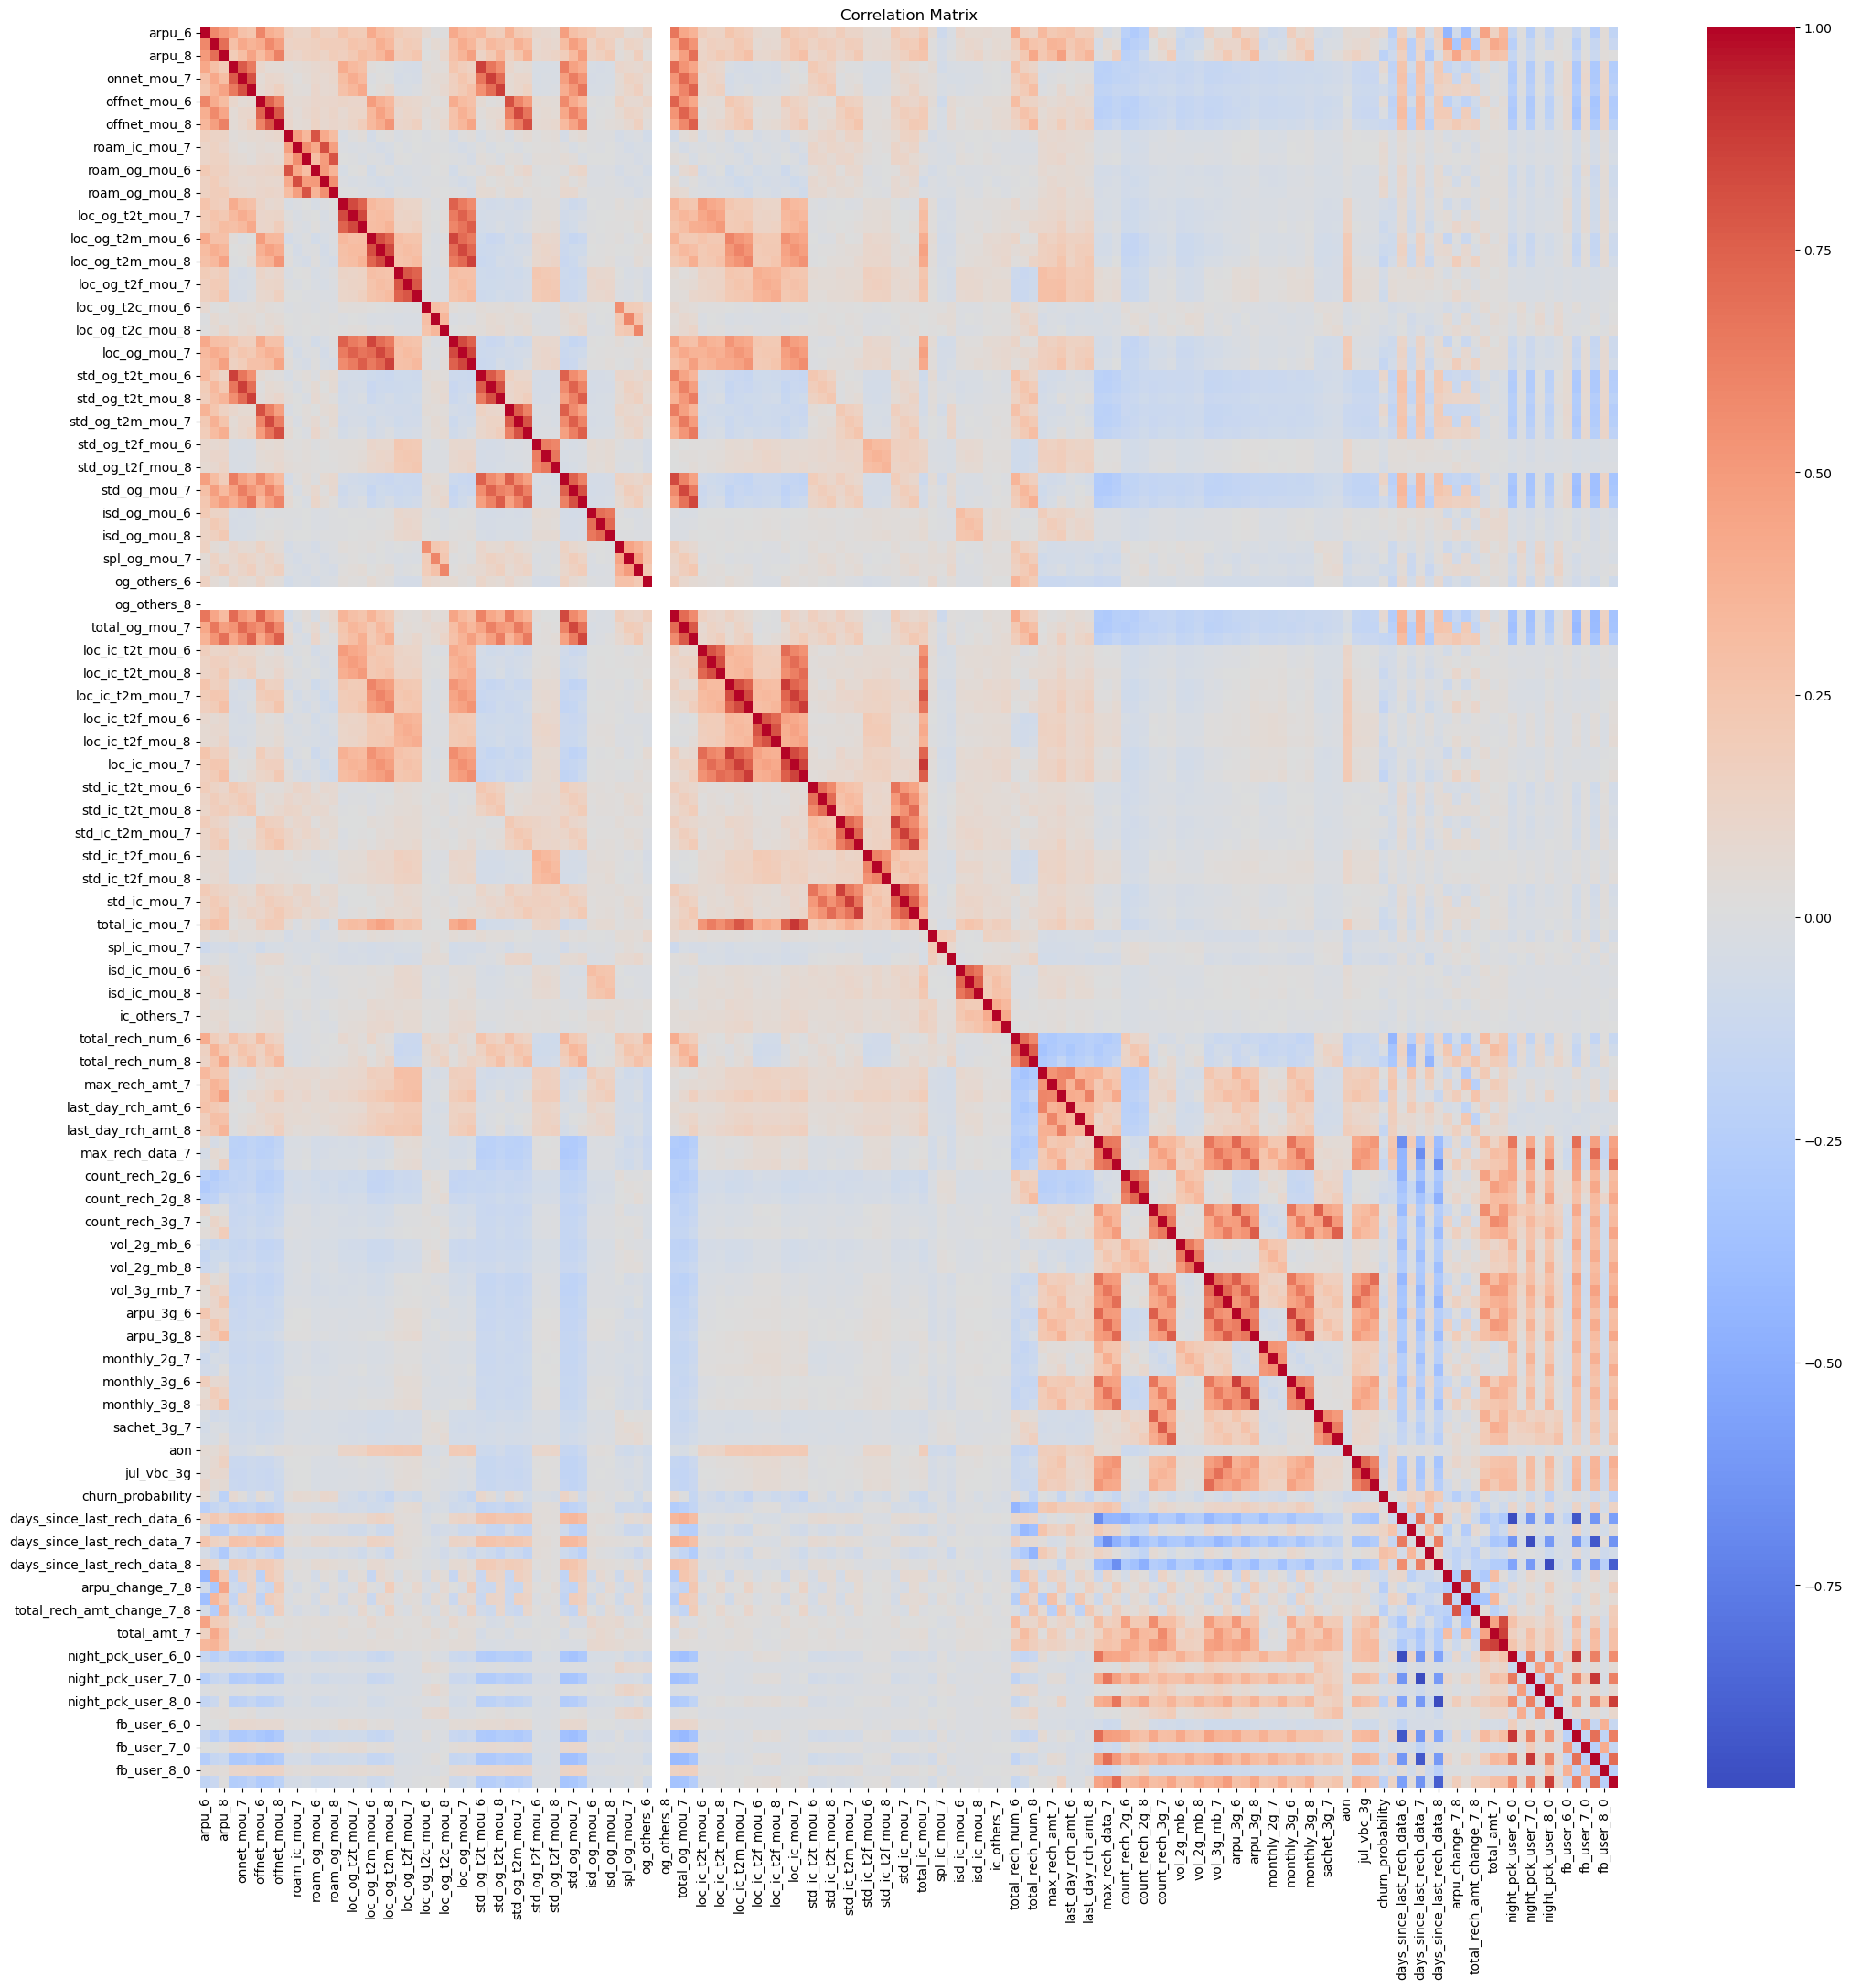

In [533]:
# Compute correlation matrix
corr_matrix = train_df.corr()

# Plot heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

<div class="alert alert-block alert-success">
Correlation Cluster is reduced now
</div>

## Splitting the Data

In [534]:
# Define your target variable and features
X = train_df.drop(columns = ['churn_probability'], axis=1)
y = train_df['churn_probability']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Unseen Test set shape:", unseen_df.shape)

Training set shape: (16798, 153)
Testing set shape: (4200, 153)
Unseen Test set shape: (30000, 153)


## PCA

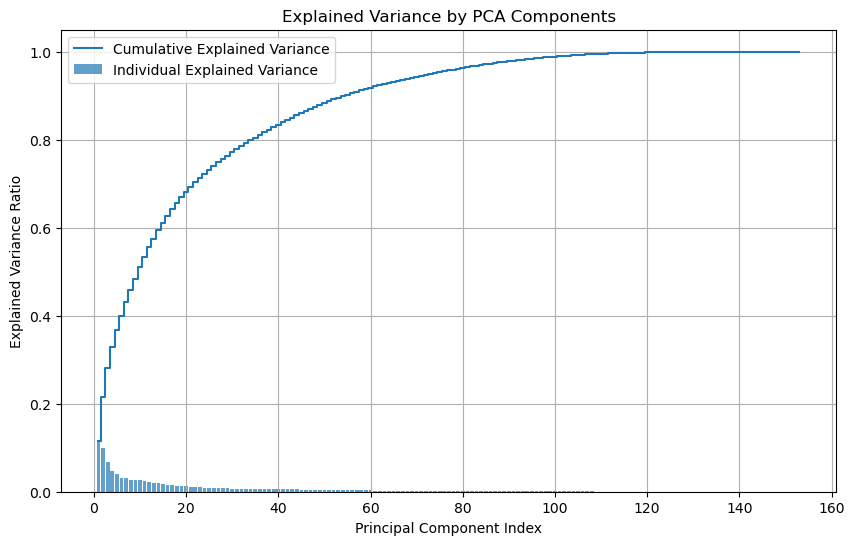

In [535]:
# Explained variance ratio and cumulative explained variance
pca = PCA()
pca.fit(X_train)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot Explained Variance Ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', label='Individual Explained Variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.grid(True)
plt.show()

<div class="alert alert-block alert-success">
After 95% variance it got little flat. So, we will move with 95% variance PCA.
</div>

In [536]:
# 95% variance PCA
pca = PCA(n_components=0.95, random_state=42)

# Fit PCA on training data
X_train_pca = pca.fit_transform(X_train)

# Transform test data
X_test_pca = pca.transform(X_test)
unseen_pca = pca.transform(unseen_df)
print(f"Number of principal components: {X_train_pca.shape[1]}")


Number of principal components: 74


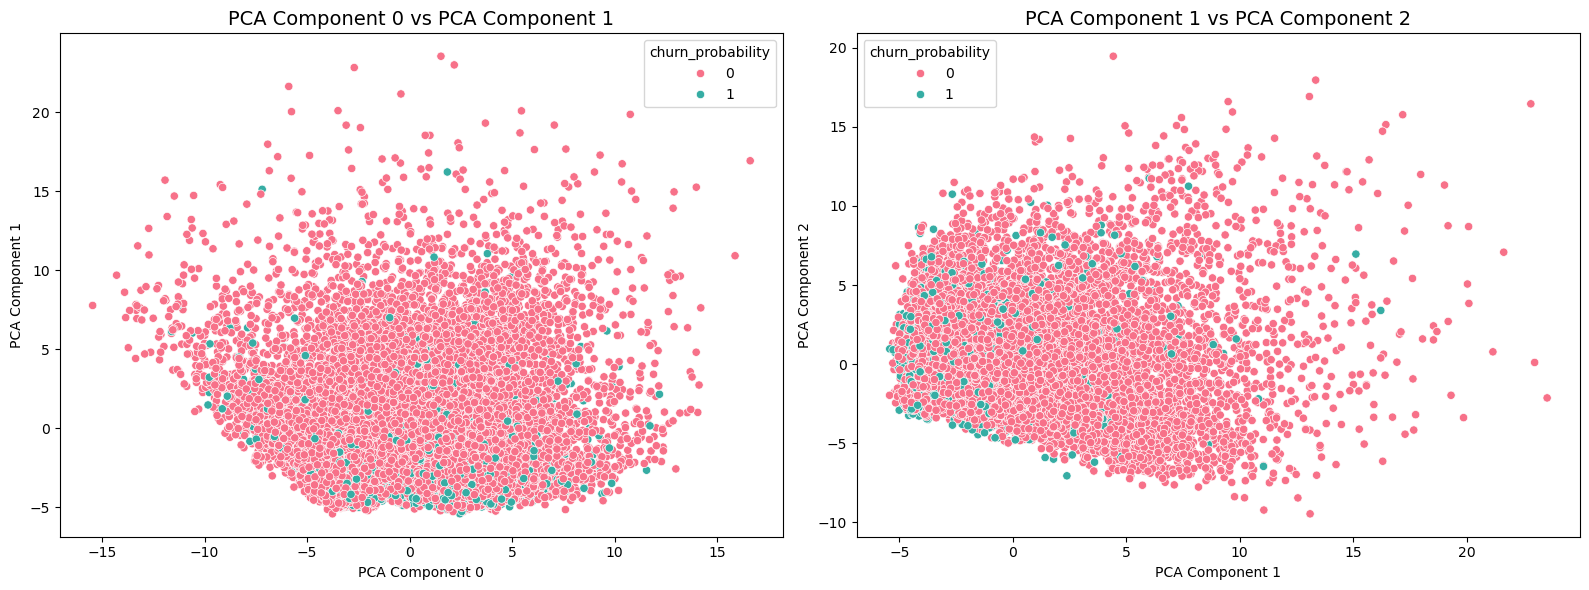

In [537]:
# figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first scatterplot (PCA Component 0 vs PCA Component 1)
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, ax=axes[0], palette='husl')
axes[0].set_title('PCA Component 0 vs PCA Component 1', fontsize=14)
axes[0].set_xlabel('PCA Component 0')
axes[0].set_ylabel('PCA Component 1')

# Plot the second scatterplot (PCA Component 1 vs PCA Component 2)
sns.scatterplot(x=X_train_pca[:, 1], y=X_train_pca[:, 2], hue=y_train, ax=axes[1], palette='husl')
axes[1].set_title('PCA Component 1 vs PCA Component 2', fontsize=14)
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

# Adjust layout for better visuals
plt.tight_layout()

# Show the plots
plt.show()

<div class="alert alert-block alert-success">
Very high imbalance of Churn_Probability. We will go with SMOTE or Scale Pos Weight to correct balance.
</div>

### Classification Metric Function

In [538]:
def compute_classification_metrics(y_actual, y_predicted):
    # Generate the confusion matrix
    confusion_mat = confusion_matrix(y_actual, y_predicted)
    print('Confusion Matrix:')
    print(confusion_mat)
    
    # Extract values from the confusion matrix
    true_positive = confusion_mat[1, 1]
    false_positive = confusion_mat[0, 1]
    true_negative = confusion_mat[0, 0]
    false_negative = confusion_mat[1, 0]

    # Calculate metrics
    accuracy = round((true_positive + true_negative) / (true_positive + false_positive + true_negative + false_negative), 4)
    recall = round(true_positive / (true_positive + false_negative), 4)  # Also known as sensitivity
    specificity = round(true_negative / (true_negative + false_positive), 4)
    precision = round(true_positive / (true_positive + false_positive), 4)
    false_positive_rate = round(false_positive / (false_positive + true_negative), 4)
    true_positive_rate = recall  # Sensitivity and TPR are equivalent

    # Create a DataFrame to store the results
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Recall (Sensitivity)', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
        'Value': [accuracy, recall, specificity, precision, false_positive_rate, true_positive_rate]
    })

    return metrics_df


## Predictive Model

### Random Forest (with SMOTE, Cross Validation and hyperparameter tuning)

In [539]:
# Define the pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest
])

# Define parameter grid with step names
param_grid = {
    'classifier__n_estimators': [100, 200],  # Random Forest hyperparameters
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5]
}

# Define Stratified K-Fold cross-validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=strat_kfold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-transformed training data
grid_search.fit(X_train_pca, y_train)

# Best parameters
print("Best parameters found:", grid_search.best_params_)

# Best estimator
best_rf_model = grid_search.best_estimator_

# Cross-validation results
cv_results = grid_search.cv_results_
print("\nCross-validation results:")
for mean_acc, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"Mean Accuracy: {mean_acc:.4f} using parameters: {params}")

# Make predictions
y_pred_best_rf = best_rf_model.predict(X_test_pca)

# Evaluate the model
print("\nOptimized Random Forest Model - Test Set Evaluation:")
print(classification_report(y_test, y_pred_best_rf))

# Calculate and display Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"Accuracy: {accuracy_rf:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  25.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  25.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  25.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  25.9s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  26.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=100; total time=  27.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=200; total time=  53.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=100; total 

In [540]:
compute_classification_metrics(y_test, y_pred_best_rf)

Confusion Matrix:
[[3684  187]
 [ 157  172]]


,Metric,Value
0,Accuracy,0.9181
1,Recall (Sensitivity),0.5228
2,Specificity,0.9517
3,Precision,0.4791
4,False Positive Rate,0.0483
5,True Positive Rate,0.5228


In [541]:
unseen_pred_rf = best_rf_model.predict(unseen_pca)
output_rf = pd.DataFrame({'id': unseen_ids,'churn_probability':unseen_pred_rf})
output_rf.to_csv('RahulSingh_RawoofMohammad_submission_rf.csv',index=False)

### XGB Classifier (with Scale Pos Weight, Cross Validation and hyperparameter tuning)

In [542]:
# Define parameter grid for XGBoost
# Scale Pos Weight value = 16.42105263157895, we got after lot of hypertuning
# scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# 'xgb__scale_pos_weight': [scale_pos_weight, scale_pos_weight * 1.5, scale_pos_weight * 2]

pipeline_xgb = Pipeline([
    ('xgb', XGBClassifier(random_state=42, scale_pos_weight = 16.42105263157895))  
])

# Calculate scale_pos_weight (For Class Imbalance)
# scale_pos_weight = (count of negative samples) / (count of positive samples)


# Define parameter grid for XGBoost
param_dist = {
    'xgb__n_estimators': [700, 800],  # XGBoost parameters
    'xgb__max_depth': [5, 7],
    'xgb__learning_rate': [0.1, 0.2]
}

# Define Stratified K-Fold cross-validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)


# Instantiate GridSearchCV with accuracy scoring
grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_dist,
    cv=strat_kfold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on the training data
grid_search_xgb.fit(X_train_pca, y_train)

# Cross-validation results
cv_results_xgb = grid_search_xgb.cv_results_
print("\nCross-validation results:")

# Display Mean Accuracy Scores
print("\nMean Accuracy Scores:")
for mean_acc, params in zip(cv_results_xgb['mean_test_score'], cv_results_xgb['params']):
    print(f"Mean Accuracy: {mean_acc:.4f} using parameters: {params}")

# Best estimator
best_xgb_model = grid_search_xgb.best_estimator_

# Make predictions on the test set
y_pred_best_xgb = best_xgb_model.predict(X_test_pca)

# Evaluate the model
print("\nOptimized XGBoost Model - Test Set Evaluation:")
print(classification_report(y_test, y_pred_best_xgb))

# Calculate and display Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_best_xgb)
print(f"Accuracy: {accuracy_xgb:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=700; total time=   9.8s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=700; total time=   9.8s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=700; total time=   9.9s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=700; total time=  10.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=700; total time=  10.2s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=800; total time=  10.6s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=800; total time=  10.7s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=800; total time=  11.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=800; total time=  11.7s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=800; total time=  11.8s
[CV] END x

In [543]:
grid_search_xgb.best_params_

{'xgb__learning_rate': 0.2, 'xgb__max_depth': 7, 'xgb__n_estimators': 800}

In [544]:
compute_classification_metrics(y_test, y_pred_best_xgb)

Confusion Matrix:
[[3777   94]
 [ 171  158]]


,Metric,Value
0,Accuracy,0.9369
1,Recall (Sensitivity),0.4802
2,Specificity,0.9757
3,Precision,0.6270
4,False Positive Rate,0.0243
5,True Positive Rate,0.4802


In [545]:
unseen_pred_xgb = best_xgb_model.predict(unseen_pca)
output_xgb = pd.DataFrame({'id': unseen_ids,'churn_probability':unseen_pred_xgb})
output_xgb.to_csv('RahulSingh_RawoofMohammad_submission_xgb.csv',index=False)

### LightGBM Classifier (with Scale Pos Weight, Cross Validation and hyperparameter tuning)

In [546]:
# Define the pipeline
# Scale Pos Weight value = 10.947368421052632 and learning_rate = 0.2, we got after lot of hypertuning
# scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# 'xgb__scale_pos_weight': [scale_pos_weight, scale_pos_weight * 1.5, scale_pos_weight * 2]

pipeline_lgbm = Pipeline([
    ('lgbm', LGBMClassifier(objective='binary', random_state=42, n_jobs=-1, scale_pos_weight = 10.947368421052632, learning_rate=0.2))  # LightGBM step
])

# Calculate scale_pos_weight (For Class Imbalance)
# scale_pos_weight = (count of negative samples) / (count of positive samples)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define parameter grid for LightGBM
param_grid_lgbm = {
    'lgbm__num_leaves': [75, 80],          
    'lgbm__max_depth': [15, 20], 
    'lgbm__n_estimators': [250, 300]
}

# Define Stratified K-Fold cross-validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate GridSearchCV with accuracy scoring
grid_search_lgbm = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid_lgbm,
    cv=strat_kfold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on the training data
grid_search_lgbm.fit(X_train_pca, y_train)

# Cross-validation results
cv_results_lgbm = grid_search_lgbm.cv_results_
print("\nCross-validation results:")

# Display Mean Accuracy Scores
print("\nMean Accuracy Scores:")
for mean_acc, params in zip(cv_results_lgbm['mean_test_score'], cv_results_lgbm['params']):
    print(f"Mean Accuracy: {mean_acc:.4f} using parameters: {params}")

# Best estimator
best_lgbm_model = grid_search_lgbm.best_estimator_

# Make predictions on the test set
y_pred_best_lgbm = best_lgbm_model.predict(X_test_pca)

# Evaluate the model
print("\nOptimized LightGBM Model - Test Set Evaluation:")
print(classification_report(y_test, y_pred_best_lgbm))

# Calculate and display Accuracy
accuracy_lgbm = accuracy_score(y_test, y_pred_best_lgbm)
print(f"Accuracy: {accuracy_lgbm:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 1125, number of negative: 12314
[LightGBM] [Info] Number of positive: 1125, number of negative: 12314
[LightGBM] [Info] Number of positive: 1125, number of negative: 12313
[LightGBM] [Info] Number of positive: 1124, number of negative: 12314
[LightGBM] [Info] Number of positive: 1124, number of negative: 12314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of positive: 1125, number of negative: 12313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1887

In [547]:
grid_search_lgbm.best_params_

{'lgbm__max_depth': 20, 'lgbm__n_estimators': 300, 'lgbm__num_leaves': 80}

In [548]:
compute_classification_metrics(y_test, y_pred_best_lgbm)

Confusion Matrix:
[[3808   63]
 [ 195  134]]


,Metric,Value
0,Accuracy,0.9386
1,Recall (Sensitivity),0.4073
2,Specificity,0.9837
3,Precision,0.6802
4,False Positive Rate,0.0163
5,True Positive Rate,0.4073


In [549]:
unseen_pred_lgbm = best_lgbm_model.predict(unseen_pca)
output_lgbm = pd.DataFrame({'id': unseen_ids,'churn_probability':unseen_pred_lgbm})
output_lgbm.to_csv('RahulSingh_RawoofMohammad_submission_lgbm.csv',index=False)

## Interpretable Model

### Logistic Regression (RFE and VIF)

In [550]:
def create_logistic_regression_model(X_train_dataframe, y_train_dataframe, feature_cols):
    # Select the desired features
    X_train_selected = X_train_dataframe[feature_cols]
    
    # Add a constant term to the predictors for the intercept
    X_train_with_constant = sm.add_constant(X_train_selected)
    
    # Initialize and fit the Logistic Regression model
    logistic_model = sm.Logit(y_train_dataframe, X_train_with_constant).fit(disp=False)
    
    # Print the model summary
    print(logistic_model.summary())
    
    return logistic_model


In [551]:
def get_VIF(X_train_dataframe, feature_cols):
    X_train_vif = X_train_dataframe[feature_cols] # Select the specified features from the training data
    
    # Initialize a DataFrame to store VIF values
    vif_df = pd.DataFrame()
    vif_df['Features'] = feature_cols
    
    # Calculate VIF for each feature
    vif_df['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
    
    vif_df['VIF'] = round(vif_df['VIF'], 2) # Round VIF values to 2 decimal places
    vif_df = vif_df.sort_values(by="VIF", ascending=False) # Sort features by VIF in descending order    
    return vif_df # Return the DataFrame containing features and their VIF values

### Recursive Feature Elimination (RFE)

In [552]:
# Fit a Logistic regression model on the training data
linear_model = LogisticRegression()
linear_model.fit(X_train, y_train) 


# Perform Recursive Feature Elimination (RFE) to select the top 15 features
rfe = RFE(estimator=linear_model, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [553]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_)) #Display features, shortlisted status, ranking

[('arpu_6', False, 64),
 ('arpu_7', False, 69),
 ('arpu_8', False, 102),
 ('onnet_mou_6', False, 18),
 ('onnet_mou_7', False, 35),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 14),
 ('offnet_mou_7', False, 21),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 126),
 ('roam_ic_mou_7', False, 86),
 ('roam_ic_mou_8', False, 85),
 ('roam_og_mou_6', False, 103),
 ('roam_og_mou_7', False, 120),
 ('roam_og_mou_8', False, 80),
 ('loc_og_t2t_mou_6', False, 71),
 ('loc_og_t2t_mou_7', False, 17),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_6', False, 55),
 ('loc_og_t2m_mou_7', False, 15),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 114),
 ('loc_og_t2f_mou_7', False, 63),
 ('loc_og_t2f_mou_8', False, 84),
 ('loc_og_t2c_mou_6', False, 108),
 ('loc_og_t2c_mou_7', False, 112),
 ('loc_og_t2c_mou_8', False, 125),
 ('loc_og_mou_6', False, 62),
 ('loc_og_mou_7', False, 16),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 70),
 ('std_og_t2t_mou_7', False, 6),
 (

In [554]:
# Features that will be eliminated
X_train.columns[~rfe.support_]

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8',
       ...
       'night_pck_user_6_0', 'night_pck_user_6_1', 'night_pck_user_7_0',
       'night_pck_user_7_1', 'night_pck_user_8_0', 'night_pck_user_8_1',
       'fb_user_6_0', 'fb_user_6_1', 'fb_user_7_1', 'fb_user_8_0'],
      dtype='object', length=138)

In [555]:
# Proceeding with RFE 15 selected variables
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

,onnet_mou_8,offnet_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,spl_ic_mou_8,last_day_rch_amt_8,fb_user_7_0,fb_user_8_1
27942,-0.543144,-0.713731,-0.411038,-0.550772,-0.578073,-0.418641,-0.456917,-0.557737,-0.769599,1.407414,-0.561479,-0.267078,0.535624,0,1
40906,1.765305,-0.282986,6.153577,0.314233,2.954668,-0.418641,-0.456917,-0.551479,0.925826,1.513566,0.006795,-0.267078,-0.350954,0,0
15017,-0.496759,-0.584644,-0.428015,-0.536803,-0.544963,-0.418641,-0.446865,-0.538170,-0.855197,-0.431316,-0.483825,-0.267078,-0.817574,1,0
50032,-0.261987,0.117966,0.358100,1.085763,0.837176,-0.418641,-0.454084,-0.556005,-0.087695,-0.262491,0.978903,-0.267078,-0.350954,0,0
25823,-0.482358,-0.808562,-0.235489,-0.733766,-0.626797,-0.418641,-0.456917,-0.557737,-0.792788,-0.449344,-0.643326,-0.267078,1.534191,0,1


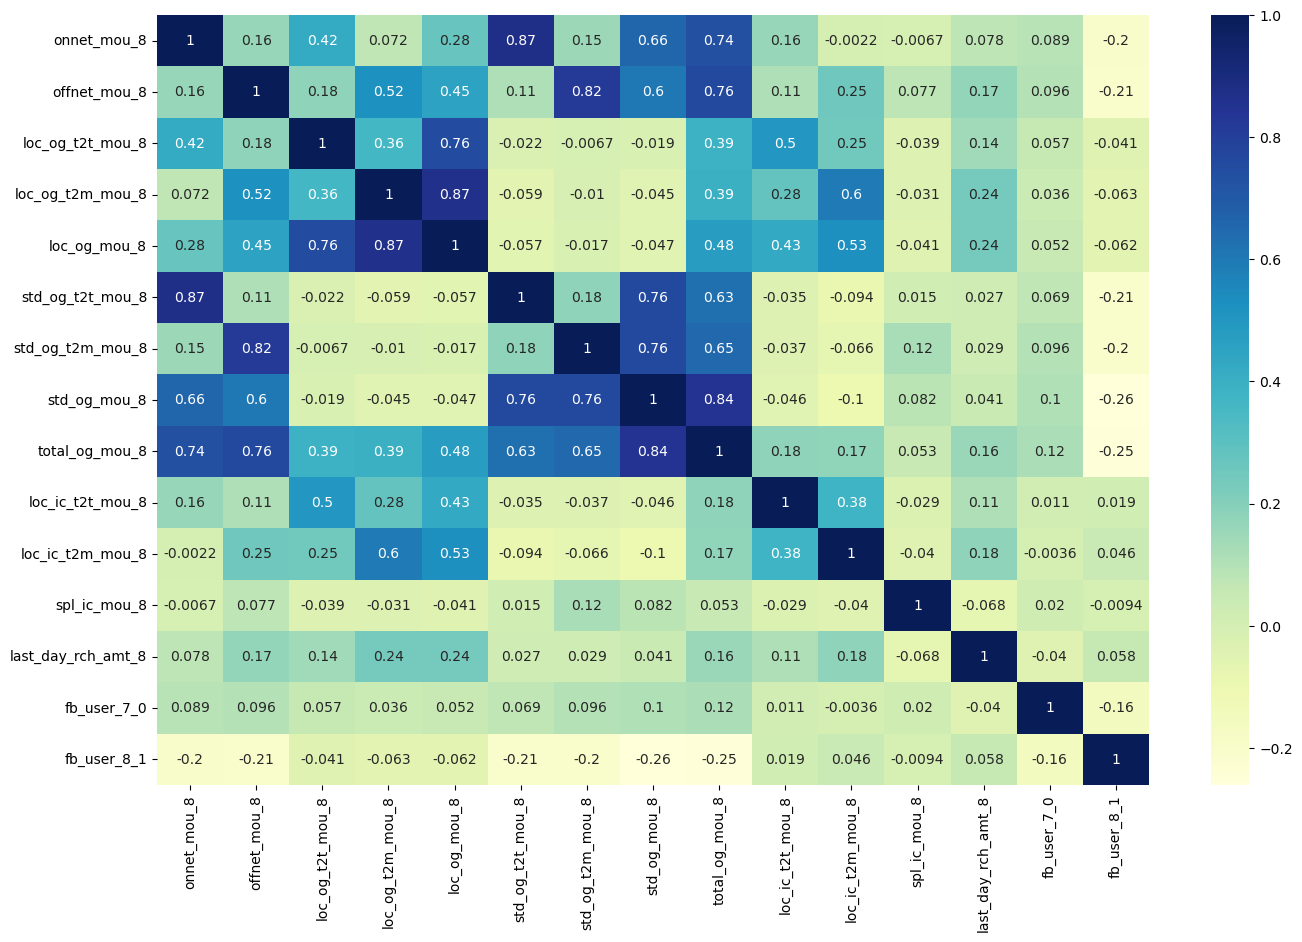

In [556]:
# Correlation coefficients to check which selected features are highly correlated

plt.figure(figsize = (16, 10))
sns.heatmap(X_train_rfe.corr(), annot = True, cmap="YlGnBu")
plt.show()

#### Model 1 (RFE)

In [557]:
#Columns shortlisted after RFE
selected_feature_cols = X_train_rfe.columns.to_list()
selected_feature_cols

['onnet_mou_8',
 'offnet_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'std_og_mou_8',
 'total_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'spl_ic_mou_8',
 'last_day_rch_amt_8',
 'fb_user_7_0',
 'fb_user_8_1']

In [558]:
logistic_model_1 = create_logistic_regression_model(X_train_dataframe = X_train_rfe, y_train_dataframe = y_train, 
                                   feature_cols = selected_feature_cols)

                           Logit Regression Results                           
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                          Logit   Df Residuals:                    16782
Method:                           MLE   Df Model:                           15
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                  0.3374
Time:                        23:12:25   Log-Likelihood:                -3202.6
converged:                       True   LL-Null:                       -4833.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.2061      0.079    -40.563      0.000      -3.361      -3.051
onnet_mou_8            0.8128      0.192      4.243      0.000       0.437       1.188
offnet_mou_8        

In [559]:
print(get_VIF(X_train_dataframe = X_train_rfe, feature_cols = selected_feature_cols)) #Print VIF (Variance Inflation Factor)

              Features     VIF
7         std_og_mou_8  129.35
8       total_og_mou_8   77.75
4         loc_og_mou_8   71.56
5     std_og_t2t_mou_8   53.85
6     std_og_t2m_mou_8   42.95
0          onnet_mou_8   38.80
3     loc_og_t2m_mou_8   29.57
1         offnet_mou_8   26.59
2     loc_og_t2t_mou_8   14.28
10    loc_ic_t2m_mou_8    1.73
9     loc_ic_t2t_mou_8    1.51
12  last_day_rch_amt_8    1.09
14         fb_user_8_1    1.06
11        spl_ic_mou_8    1.02
13         fb_user_7_0    1.02


<div class="alert alert-block alert-success">

Using below thresholds:
1. **p-value below 0.05** meaning feature is **significant**.
2. **VIF above 5 meaning feature has higher correlation** with other features/independent variables.
</div>

#### Model 2<br>
<div class="alert alert-block alert-success">std_og_mou_8 has very high VIF</div>

In [560]:
#Remove column 'std_og_mou_8'
selected_feature_cols.remove('std_og_mou_8')
selected_feature_cols

['onnet_mou_8',
 'offnet_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'total_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'spl_ic_mou_8',
 'last_day_rch_amt_8',
 'fb_user_7_0',
 'fb_user_8_1']

In [561]:
logistic_model_2 = create_logistic_regression_model(X_train_dataframe = X_train_rfe, y_train_dataframe = y_train, 
                                   feature_cols = selected_feature_cols) # Create a Linear Regression Model and print Summary

                           Logit Regression Results                           
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                          Logit   Df Residuals:                    16783
Method:                           MLE   Df Model:                           14
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                  0.3025
Time:                        23:12:26   Log-Likelihood:                -3371.2
converged:                       True   LL-Null:                       -4833.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.0941      0.077    -40.135      0.000      -3.245      -2.943
onnet_mou_8            0.6964      0.191      3.640      0.000       0.321       1.071
offnet_mou_8        

In [562]:
print(get_VIF(X_train_dataframe = X_train_rfe, feature_cols = selected_feature_cols)) #Print VIF (Variance Inflation Factor)

              Features    VIF
4         loc_og_mou_8  59.76
7       total_og_mou_8  37.78
0          onnet_mou_8  37.06
5     std_og_t2t_mou_8  29.36
3     loc_og_t2m_mou_8  29.22
1         offnet_mou_8  26.01
6     std_og_t2m_mou_8  23.15
2     loc_og_t2t_mou_8  13.99
9     loc_ic_t2m_mou_8   1.73
8     loc_ic_t2t_mou_8   1.51
11  last_day_rch_amt_8   1.09
13         fb_user_8_1   1.06
10        spl_ic_mou_8   1.02
12         fb_user_7_0   1.02


#### Model 3:<br>
<div class="alert alert-block alert-success"> All features are significant but loc_og_mou_8 has very high VIF (> 5)</div>

In [563]:
#Remove column 'loc_og_mou_8'
selected_feature_cols.remove('loc_og_mou_8')
selected_feature_cols

['onnet_mou_8',
 'offnet_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'total_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'spl_ic_mou_8',
 'last_day_rch_amt_8',
 'fb_user_7_0',
 'fb_user_8_1']

In [564]:
logistic_model_3 = create_logistic_regression_model(X_train_dataframe = X_train_rfe, y_train_dataframe = y_train, 
                                   feature_cols = selected_feature_cols) # Create a Linear Regression Model and print Summary

                           Logit Regression Results                           
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                          Logit   Df Residuals:                    16784
Method:                           MLE   Df Model:                           13
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                  0.2934
Time:                        23:12:26   Log-Likelihood:                -3415.2
converged:                       True   LL-Null:                       -4833.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.0438      0.077    -39.508      0.000      -3.195      -2.893
onnet_mou_8            0.8441      0.206      4.088      0.000       0.439       1.249
offnet_mou_8        

In [565]:
print(get_VIF(X_train_dataframe = X_train_rfe, feature_cols = selected_feature_cols)) #Print VIF (Variance Inflation Factor)

              Features    VIF
0          onnet_mou_8  34.16
6       total_og_mou_8  33.00
1         offnet_mou_8  25.80
4     std_og_t2t_mou_8  21.78
5     std_og_t2m_mou_8  20.47
3     loc_og_t2m_mou_8  10.10
2     loc_og_t2t_mou_8   7.39
8     loc_ic_t2m_mou_8   1.73
7     loc_ic_t2t_mou_8   1.50
10  last_day_rch_amt_8   1.09
12         fb_user_8_1   1.06
9         spl_ic_mou_8   1.02
11         fb_user_7_0   1.02


#### Model 4:<br>
<div class="alert alert-block alert-success">All features are significant but onnet_mou_8 has very high VIF (> 5)</div>

In [566]:
#Remove column 'onnet_mou_8'
selected_feature_cols.remove('onnet_mou_8')
selected_feature_cols

['offnet_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'total_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'spl_ic_mou_8',
 'last_day_rch_amt_8',
 'fb_user_7_0',
 'fb_user_8_1']

In [567]:
logistic_model_4 = create_logistic_regression_model(X_train_dataframe = X_train_rfe, y_train_dataframe = y_train, 
                                   feature_cols = selected_feature_cols) # Create a Linear Regression Model and print Summary

                           Logit Regression Results                           
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                          Logit   Df Residuals:                    16785
Method:                           MLE   Df Model:                           12
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                  0.2917
Time:                        23:12:27   Log-Likelihood:                -3423.3
converged:                       True   LL-Null:                       -4833.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.0574      0.077    -39.725      0.000      -3.208      -2.907
offnet_mou_8           1.1131      0.141      7.884      0.000       0.836       1.390
loc_og_t2t_mou_8    

In [568]:
print(get_VIF(X_train_dataframe = X_train_rfe, feature_cols = selected_feature_cols)) #Print VIF (Variance Inflation Factor)

              Features    VIF
0         offnet_mou_8  25.79
5       total_og_mou_8  25.07
4     std_og_t2m_mou_8  17.56
3     std_og_t2t_mou_8   8.93
2     loc_og_t2m_mou_8   8.66
1     loc_og_t2t_mou_8   3.67
7     loc_ic_t2m_mou_8   1.73
6     loc_ic_t2t_mou_8   1.48
9   last_day_rch_amt_8   1.09
11         fb_user_8_1   1.06
8         spl_ic_mou_8   1.02
10         fb_user_7_0   1.02


#### Model 5: <br>
<div class="alert alert-block alert-success">All features are significant but offnet_mou_8 has very high VIF (> 5)</div>

In [569]:
#Remove column 'offnet_mou_8'
selected_feature_cols.remove('offnet_mou_8')
selected_feature_cols

['loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'total_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'spl_ic_mou_8',
 'last_day_rch_amt_8',
 'fb_user_7_0',
 'fb_user_8_1']

In [570]:
logistic_model_5 = create_logistic_regression_model(X_train_dataframe = X_train_rfe, y_train_dataframe = y_train, 
                                   feature_cols = selected_feature_cols) # Create a Linear Regression Model and print Summary

                           Logit Regression Results                           
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                          Logit   Df Residuals:                    16786
Method:                           MLE   Df Model:                           11
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                  0.2851
Time:                        23:12:27   Log-Likelihood:                -3455.2
converged:                       True   LL-Null:                       -4833.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.0548      0.077    -39.512      0.000      -3.206      -2.903
loc_og_t2t_mou_8       1.2551      0.157      8.000      0.000       0.948       1.563
loc_og_t2m_mou_8    

In [571]:
print(get_VIF(X_train_dataframe = X_train_rfe, feature_cols = selected_feature_cols)) #Print VIF (Variance Inflation Factor)

              Features    VIF
4       total_og_mou_8  21.54
2     std_og_t2t_mou_8   7.74
3     std_og_t2m_mou_8   7.74
1     loc_og_t2m_mou_8   4.12
0     loc_og_t2t_mou_8   3.32
6     loc_ic_t2m_mou_8   1.72
5     loc_ic_t2t_mou_8   1.48
8   last_day_rch_amt_8   1.08
10         fb_user_8_1   1.06
7         spl_ic_mou_8   1.02
9          fb_user_7_0   1.02


#### Model 6:<br>
<div class="alert alert-block alert-success">All features are significant but total_og_mou_8 has very high VIF (> 5)</div>

In [572]:
#Remove column 'total_og_mou_8'
selected_feature_cols.remove('total_og_mou_8')
selected_feature_cols

['loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'spl_ic_mou_8',
 'last_day_rch_amt_8',
 'fb_user_7_0',
 'fb_user_8_1']

In [573]:
logistic_model_6 = create_logistic_regression_model(X_train_dataframe = X_train_rfe, y_train_dataframe = y_train, 
                                   feature_cols = selected_feature_cols) # Create a Linear Regression Model and print Summary

                           Logit Regression Results                           
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                          Logit   Df Residuals:                    16787
Method:                           MLE   Df Model:                           10
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                  0.2727
Time:                        23:12:28   Log-Likelihood:                -3515.3
converged:                       True   LL-Null:                       -4833.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.8088      0.070    -39.888      0.000      -2.947      -2.671
loc_og_t2t_mou_8      -0.2366      0.074     -3.207      0.001      -0.381      -0.092
loc_og_t2m_mou_8    

In [574]:
print(get_VIF(X_train_dataframe = X_train_rfe, feature_cols = selected_feature_cols)) #Print VIF (Variance Inflation Factor)

             Features   VIF
1    loc_og_t2m_mou_8  1.74
5    loc_ic_t2m_mou_8  1.72
4    loc_ic_t2t_mou_8  1.47
0    loc_og_t2t_mou_8  1.46
3    std_og_t2m_mou_8  1.08
7  last_day_rch_amt_8  1.08
2    std_og_t2t_mou_8  1.07
9         fb_user_8_1  1.06
6        spl_ic_mou_8  1.02
8         fb_user_7_0  1.02


<div class="alert alert-block alert-success">Since, all VIF is below 5 and all features are significant. This will be our final interpretable model.</div>

<b>Equation</b>
P(churn_probability) = -2.8088 - 0.2366 * loc_og_t2t_mou_8 - 0.6678 * loc_og_t2m_mou_8 - 0.4004 * std_og_t2t_mou_8 - 0.4716 * std_og_t2m_mou_8 - 0.4184 * loc_ic_t2t_mou_8 - 0.8591 * loc_ic_t2m_mou_8 - 0.9355 * spl_ic_mou_8 - 0.6277 * last_day_rch_amt_8 - 0.6215 * fb_user_7_0 - 2.0734 * fb_user_8_1


### Important Features
1. fb_user_8_1 (-2.0734): Most impactful, related to Facebook usage in August.
2. spl_ic_mou_8 (-0.9355): Strongly associated with special incoming call minutes in August.
3. loc_ic_t2m_mou_8 (-0.8591): Significant influence from local incoming minutes in August.
4. last_day_rch_amt_8 (-0.6277): Recharge amount on the last day of August.
5. fb_user_7_0 (-0.6215): Facebook usage indicator in July.
6. loc_og_t2m_mou_8 (-0.6678): Local outgoing mobile minutes in August.
7. std_og_t2m_mou_8 (-0.4716): Standard outgoing mobile minutes in August.
8. loc_ic_t2t_mou_8 (-0.4184): Local incoming talk minutes in August.
9. std_og_t2t_mou_8 (-0.4004): Standard outgoing talk minutes in August.
10. loc_og_t2t_mou_8 (-0.2366): Local outgoing talk minutes in August.

## Next Steps:

### **1. Focus on Customers at High Risk of Churn**
   - **Key Indicators**:
     - Customers heavily using Facebook (`fb_user_8_1` and `fb_user_7_0`) or with low recharge amounts (`last_day_rch_amt_8`) are more likely to churn.
   - **What to Do**:
     - Offer incentives like bonus data or discounts to customers with low recharge patterns or declining Facebook activity to re-engage them.

---

### **2. Boost Customer Engagement**
   - **Key Insights**:
     - Reduced outgoing and incoming call activity (e.g., `loc_og_t2m_mou_8`, `std_og_t2t_mou_8`, and `loc_ic_t2m_mou_8`) is linked to higher churn.
   - **What to Do**:
     - Reward loyal users with personalized offers or loyalty programs to encourage continued usage.

---

### **3. Revive Special Call Features**
   - **Key Insight**:
     - Declining use of special incoming calls (`spl_ic_mou_8`) is a churn signal.
   - **What to Do**:
     - Investigate why these features are less used. Promote them with bundled offers or enhance their value.

---

### **4. Retain Facebook Users**
   - **Key Insight**:
     - A drop in Facebook-related activity correlates strongly with churn.
   - **What to Do**:
     - Partner with Facebook to offer exclusive data packs or discounts. Re-engage inactive users with targeted campaigns.

---

### **5. Promote Regular Recharges**
   - **Key Insight**:
     - Lower recharge activity (`last_day_rch_amt_8`) signals disengagement.
   - **What to Do**:
     - Run campaigns offering cashback or free data for consistent recharges, focusing on users who recently reduced their spending.

---

### **6. Identify and Retain At-Risk Customers Early**
   - **Key Insight**:
     - High churn probability can be detected early in the month.
   - **What to Do**:
     - Use churn probability scores (e.g., > 0.7) to identify at-risk customers and reach out via SMS, email, or calls with tailored offers.

---

### **7. Monitor Trends and Update Strategies**
   - **Key Insight**:
     - Churn patterns evolve over time.
   - **What to Do**:
     - Continuously refine predictive models and strategies to align with changing customer behavior.

---

### **8. Adapt to New Communication Preferences**
   - **Key Insight**:
     - Reduced call and Facebook usage may indicate a shift to other platforms like WhatsApp.
   - **What to Do**:
     - Offer service packages that support popular communication platforms or partner with them to enhance customer value.